https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 75 e todos)
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Oversample
        * SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (estratificada, 10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * KNN
    * Métricas de desempenho por threshold (0,2, 0,5 e 0,7)
        * F1-score positivo (iteração por iteração)
        * F1-score negativo (iteração por iteração)
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int64        0   590540     2987000      2987001   
1          isFraud    int64        0        2           0            0   
2    TransactionDT    int64        0   573349       86400        86401   
3   TransactionAmt  float64        0    20902        68.5         29.0   
4        ProductCD   object        0        5           W            W   
5            card1    int64        0    13553       13926         2755   
6            card2  float64     8933      500         NaN        404.0   
7            card3  float64     1565      114       150.0        150.0   
8            card4   object     1577        4    discover   mastercard   
9            card5  float64     4259      119       142.0        102.0   
10           card6   object     1571        4      credit       credit   
11           addr1  float64    65706      332       315.0        325.0   
12           addr2  float64    65706       74        87.0         87.0   
13           dist1  float64   352271     2651        19.0          NaN   
14           dist2  float64   552913     1751         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float64        0     1657         1.0          1.0   
18              C2  float64        0     1216         1.0          1.0   
19              C3  float64        0       27         0.0          0.0   
20              C4  float64        0     1260         0.0          0.0   
21              C5  float64        0      319         0.0          0.0   
22              C6  float64        0     1328         1.0          1.0   
23              C7  float64        0     1103         0.0          0.0   
24              C8  float64        0     1253         0.0          0.0   

    Third Value             Entropy  
0       2987002  19.170000000000002  
1             0   0.220000000000000  
2         86469  19.109999999999999  
3          59.0   8.350000000000000  
4             W   1.280000000000000  
5          4663   9.970000000000001  
6         490.0   6.320000000000000  
7         150.0   0.680000000000000  
8          visa   1.090000000000000  
9         166.0   2.660000000000000  
10        debit   0.820000000000000  
11        330.0   5.060000000000000  
12         87.0   0.080000000000000  
13        287.0   6.340000000000000  
14          NaN   7.420000000000000  
15  outlook.com   2.680000000000000  
16          NaN   2.760000000000000  
17          1.0   2.720000000000000  
18          1.0   2.750000000000000  
19          0.0   0.040000000000000  
20          0.0   1.120000000000000  
21          0.0   2.060000000000000  
22          1.0   2.520000000000000  
23          0.0   0.710000000000000  
24          0.0   1.250000000000000

In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


Name   dtypes  Missing  Uniques         First Value  \
0    TransactionID    int64        0   506691             3663549   
1    TransactionDT    int64        0   494686            18403224   
2   TransactionAmt  float64        0    14119  31.949999999999999   
3        ProductCD   object        0        5                   W   
4            card1    int64        0    13244               10409   
5            card2  float64     8654      497               111.0   
6            card3  float64     3002      115               150.0   
7            card4   object     3086        4                visa   
8            card5  float64     4547      102               226.0   
9            card6   object     3007        3               debit   
10           addr1  float64    65609      292               170.0   
11           addr2  float64    65609       72                87.0   
12           dist1  float64   291217     1988                 1.0   
13           dist2  float64   470255     1814                 NaN   
14   P_emaildomain   object    69192       60           gmail.com   
15   R_emaildomain   object   370821       60                 NaN   
16              C1  float64        3     1174                 6.0   
17              C2  float64        3     1123                 6.0   
18              C3  float64        3       31                 0.0   
19              C4  float64        3      728                 0.0   
20              C5  float64        3      353                 3.0   
21              C6  float64        3      834                 4.0   
22              C7  float64        3      518                 0.0   
23              C8  float64        3      442                 0.0   
24              C9  float64        3      354                 6.0   

   Second Value  Third Value             Entropy  
0       3663550      3663551  18.949999999999999  
1      18403263     18403310  18.899999999999999  
2          49.0        171.0   8.080000000000000  
3             W            W   1.370000000000000  
4          4272         4476   9.949999999999999  
5         111.0        574.0   6.280000000000000  
6         150.0        150.0   0.810000000000000  
7          visa         visa   1.050000000000000  
8         226.0        226.0   2.630000000000000  
9         debit        debit   0.790000000000000  
10        299.0        472.0   5.100000000000000  
11         87.0         87.0   0.110000000000000  
12          4.0       2635.0   5.990000000000000  
13          NaN          NaN   7.900000000000000  
14      aol.com  hotmail.com   2.670000000000000  
15          NaN          NaN   2.690000000000000  
16          3.0          2.0   2.680000000000000  
17          2.0          2.0   2.760000000000000  
18          0.0          0.0   0.180000000000000  
19          0.0          0.0   1.210000000000000  
20          0.0          0.0   1.930000000000000  
21          1.0          5.0   2.470000000000000  
22          0.0          0.0   0.820000000000000  
23          0.0          0.0   1.360000000000000  
24          2.0          4.0   2.610000000000000

In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

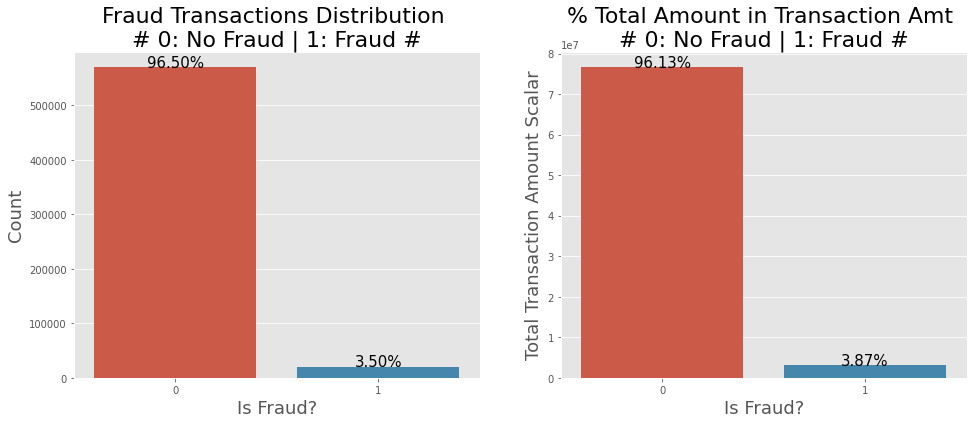

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 99.19615944728554%
id_25: 99.13096487960172%
id_26: 99.12571544687913%
id_27: 99.1246994276425%
id_28: 76.12727334304196%
id_29: 76.12727334304196%
id_30: 86.86541131845429%
id_31: 76.24513157449114%
id_32: 86.86185525112609%
id_33: 87.58949436109323%
id_34: 86.82477054898906%
id_35: 76.12608798726589%
id_36: 76.12608798726589%
id_37: 76.12608798726589%
id_38: 76.12608798726589%
DeviceType: 76.15572188166763%
DeviceInfo: 79.90551021099333%
Date: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


Name   dtypes  Missing  Uniques First Value Second Value  \
0          isFraud    int64        0        2           0            0   
1   TransactionAmt  float64        0    20902        68.5         29.0   
2        ProductCD   object        0        5           W            W   
3            card1    int64        0    13553       13926         2755   
4            card2  float64     8933      500         NaN        404.0   
5            card4   object     1577        4    discover   mastercard   
6            card5  float64     4259      119       142.0        102.0   
7            addr1  float64    65706      332       315.0        325.0   
8            dist1  float64   352271     2651        19.0          NaN   
9    P_emaildomain   object    94456       59         NaN    gmail.com   
10              C1  float64        0     1657         1.0          1.0   
11              C2  float64        0     1216         1.0          1.0   
12              C5  float64        0      319         0.0          0.0   
13              C6  float64        0     1328         1.0          1.0   
14              C9  float64        0      205         1.0          0.0   
15             C11  float64        0     1476         2.0          1.0   
16             C13  float64        0     1597         1.0          1.0   
17             C14  float64        0     1108         1.0          1.0   
18              D1  float64     1269      641        14.0          0.0   
19              D2  float64   280797      641         NaN          NaN   
20              D3  float64   262878      649        13.0          NaN   
21              D4  float64   168922      808         NaN          0.0   
22              D5  float64   309841      688         NaN          NaN   
23             D10  float64    76022      818        13.0          0.0   
24             D11  float64   279287      676        13.0          NaN   
25             D15  float64    89113      859         0.0          0.0   
26              M1   object   271100        2           T          NaN   
27              M2   object   271100        2           T          NaN   
28              M3   object   271100        2           T          NaN   
29              M4   object   281444        3          M2           M0   
30              M5   object   350482        2           F            T   
31              M6   object   169360        2           T            T   
32              M7   object   346265        2         NaN          NaN   
33              M8   object   346252        2         NaN          NaN   
34              M9   object   346252        2         NaN          NaN   
35              V1  float64   279287        2         1.0          NaN   
36              V2  float64   279287        9         1.0          NaN   
37              V3  float64   279287       10         1.0          NaN   
38              V4  float64   279287        7         1.0          NaN   
39              V5  float64   279287        7         1.0          NaN   
40              V6  float64   279287       10         1.0          NaN   
41              V7  float64   279287       10         1.0          NaN   
42              V8  float64   279287        9         1.0          NaN   
43              V9  float64   279287        9         1.0          NaN   
44             V10  float64   279287        5         0.0          NaN   
45             V11  float64   279287        6         0.0          NaN   
46             V12  float64    76073        4         1.0          0.0   
47             V13  float64    76073        7         1.0          0.0   
48             V29  float64    76073        6         0.0          0.0   
49             V30  float64    76073        8         0.0          0.0   
50             V35  float64   168969        4         NaN          0.0   
51             V36  float64   168969        6         NaN          0.0   
52             V39  float64   168969       16         NaN          0.0   
53             V40

In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [57]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [58]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Balanceamento de Classes

### Oversampling com SMOTE

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
smote = SMOTE(random_state=42)

In [61]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 6.5 s, sys: 1.05 s, total: 7.55 s
Wall time: 2.69 s


In [62]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [63]:
from imblearn.over_sampling import ADASYN

In [64]:
adasyn = ADASYN(random_state=42)

In [65]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 4s, sys: 521 ms, total: 2min 5s
Wall time: 13.3 s


In [66]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456567
0    455902
Name: count, dtype: int64

In [67]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 9.4e+01 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [68]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Oversampling com SMOTE

In [69]:
# selecionando os 75 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_75_chi2 = SelectKBest(chi2, k = 75)
new_75_chi2 = model_75_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_75_chi2 = new_75_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_75_chi2.get_support(indices = True)
features_df_new_75_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [70]:
oversample_with_smote_cols_75_chi2 = features_df_new_75_chi2.columns

In [71]:
oversample_with_smote_cols_75_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93',
       'V96', 'V99', 'V127', 'V130', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_outlook.com', 'M4_M0', 'M4_M2', 'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

### Oversampling com AdaSyn

In [72]:
# selecionando os 75 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_75_chi2 = SelectKBest(chi2, k = 75)
new_75_chi2 = model_75_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_75_chi2 = new_75_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_75_chi2.get_support(indices = True)
features_df_new_75_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [73]:
oversample_with_adasyn_cols_75_chi2 = features_df_new_75_chi2.columns

In [74]:
oversample_with_adasyn_cols_75_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V99', 'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'card4_mastercard', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_outlook.com', 'M4_M2',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [77]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [78]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

## Validação Cruzada para Oversampling com SMOTE

### 75 Chi-Square

#### Extra Trees

F1-Score Positivo (Teste): 0.6017080745341615
F1-Score Negativo (Teste): 0.9818336343354934
F1-Score Positivo Médio (Validação Cruzada): 0.5075195207279304
F1-Score Positivo Fold 1: 0.4939130434782608
F1-Score Positivo Fold 2: 0.5016949152542373
F1-Score Positivo Fold 3: 0.4938271604938271
F1-Score Positivo Fold 4: 0.4868651488616463
F1-Score Positivo Fold 5: 0.46913580246913583
F1-Score Positivo Fold 6: 0.5186440677966101
F1-Score Positivo Fold 7: 0.4956970740103271
F1-Score Positivo Fold 8: 0.5344827586206897
F1-Score Positivo Fold 9: 0.5542570951585977
F1-Score Positivo Fold 10: 0.5266781411359724
F1-Score Negativo Médio (Validação Cruzada): 0.9876094351385195
F1-Score Negativo Fold 1: 0.9873736278040526
F1-Score Negativo Fold 2: 0.9872351510941298
F1-Score Negativo Fold 3: 0.9875515072652353
F1-Score Negativo Fold 4: 0.987289054704785
F1-Score Negativo Fold 5: 0.986944263717198
F1-Score Negativo Fold 6: 0.9876693296283432
F1-Score Negativo Fold 7: 0.9872835380408836
F1-Score Negati

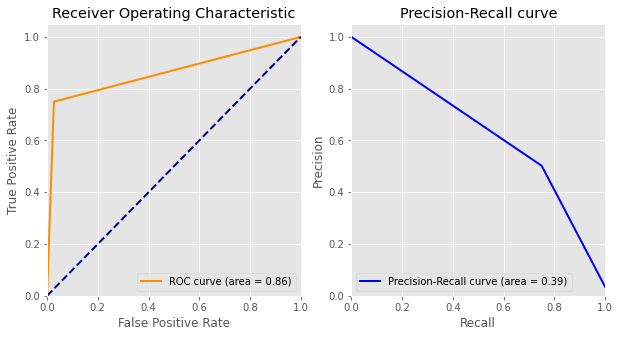

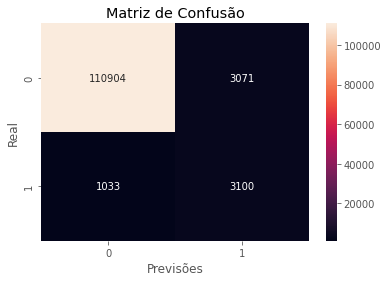

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    113975
           1       0.50      0.75      0.60      4133

    accuracy                           0.97    118108
   macro avg       0.75      0.86      0.79    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 6min 20s, sys: 494 ms, total: 6min 20s
Wall time: 6min 20s


In [79]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.6707512764405544
F1-Score Negativo (Teste): 0.9901596173717415
F1-Score Positivo Médio (Validação Cruzada): 0.5075195207279304
F1-Score Positivo Fold 1: 0.4939130434782608
F1-Score Positivo Fold 2: 0.5016949152542373
F1-Score Positivo Fold 3: 0.4938271604938271
F1-Score Positivo Fold 4: 0.4868651488616463
F1-Score Positivo Fold 5: 0.46913580246913583
F1-Score Positivo Fold 6: 0.5186440677966101
F1-Score Positivo Fold 7: 0.4956970740103271
F1-Score Positivo Fold 8: 0.5344827586206897
F1-Score Positivo Fold 9: 0.5542570951585977
F1-Score Positivo Fold 10: 0.5266781411359724
F1-Score Negativo Médio (Validação Cruzada): 0.9876094351385195
F1-Score Negativo Fold 1: 0.9873736278040526
F1-Score Negativo Fold 2: 0.9872351510941298
F1-Score Negativo Fold 3: 0.9875515072652353
F1-Score Negativo Fold 4: 0.987289054704785
F1-Score Negativo Fold 5: 0.986944263717198
F1-Score Negativo Fold 6: 0.9876693296283432
F1-Score Negativo Fold 7: 0.9872835380408836
F1-Score Negati

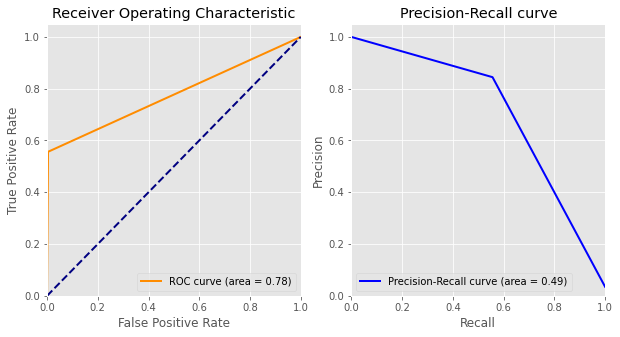

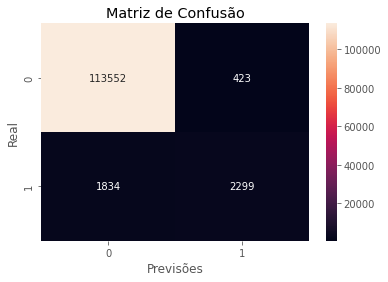

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.84      0.56      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.91      0.78      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 6min 14s, sys: 332 ms, total: 6min 15s
Wall time: 6min 14s


In [80]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.5756358768406962
F1-Score Negativo (Teste): 0.9889854065323141
F1-Score Positivo Médio (Validação Cruzada): 0.5075195207279304
F1-Score Positivo Fold 1: 0.4939130434782608
F1-Score Positivo Fold 2: 0.5016949152542373
F1-Score Positivo Fold 3: 0.4938271604938271
F1-Score Positivo Fold 4: 0.4868651488616463
F1-Score Positivo Fold 5: 0.46913580246913583
F1-Score Positivo Fold 6: 0.5186440677966101
F1-Score Positivo Fold 7: 0.4956970740103271
F1-Score Positivo Fold 8: 0.5344827586206897
F1-Score Positivo Fold 9: 0.5542570951585977
F1-Score Positivo Fold 10: 0.5266781411359724
F1-Score Negativo Médio (Validação Cruzada): 0.9876094351385195
F1-Score Negativo Fold 1: 0.9873736278040526
F1-Score Negativo Fold 2: 0.9872351510941298
F1-Score Negativo Fold 3: 0.9875515072652353
F1-Score Negativo Fold 4: 0.987289054704785
F1-Score Negativo Fold 5: 0.986944263717198
F1-Score Negativo Fold 6: 0.9876693296283432
F1-Score Negativo Fold 7: 0.9872835380408836
F1-Score Negati

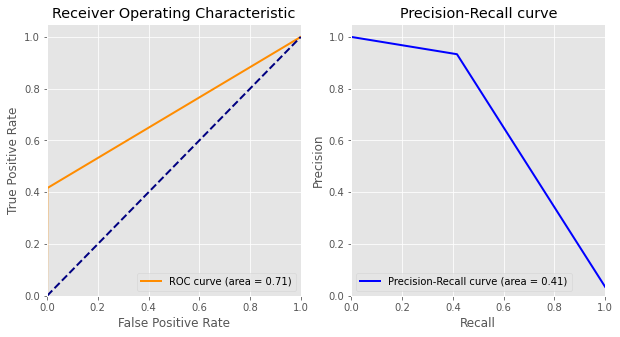

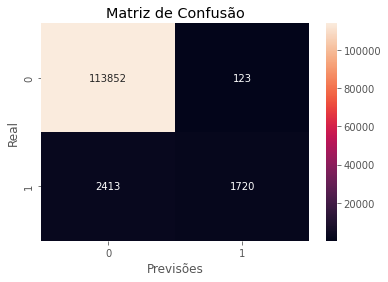

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.93      0.42      0.58      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.71      0.78    118108
weighted avg       0.98      0.98      0.97    118108

CPU times: user 6min 14s, sys: 360 ms, total: 6min 14s
Wall time: 6min 14s


In [81]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Decision Tree

F1-Score Positivo (Teste): 0.4938801803736311
F1-Score Negativo (Teste): 0.9792245110223797
F1-Score Positivo Médio (Validação Cruzada): 0.4233231931376068
F1-Score Positivo Fold 1: 0.44697833523375147
F1-Score Positivo Fold 2: 0.41505131128848344
F1-Score Positivo Fold 3: 0.4627906976744186
F1-Score Positivo Fold 4: 0.411214953271028
F1-Score Positivo Fold 5: 0.3932203389830508
F1-Score Positivo Fold 6: 0.41834451901565994
F1-Score Positivo Fold 7: 0.40893854748603353
F1-Score Positivo Fold 8: 0.44493392070484583
F1-Score Positivo Fold 9: 0.4127332601536773
F1-Score Positivo Fold 10: 0.41902604756511896
F1-Score Negativo Médio (Validação Cruzada): 0.9775603280303814
F1-Score Negativo Fold 1: 0.9786766322268632
F1-Score Negativo Fold 2: 0.9774455924378983
F1-Score Negativo Fold 3: 0.9797030137949213
F1-Score Negativo Fold 4: 0.9778617236229465
F1-Score Negativo Fold 5: 0.9763821084575801
F1-Score Negativo Fold 6: 0.9771207321365717
F1-Score Negativo Fold 7: 0.9767237206846482
F1-Score 

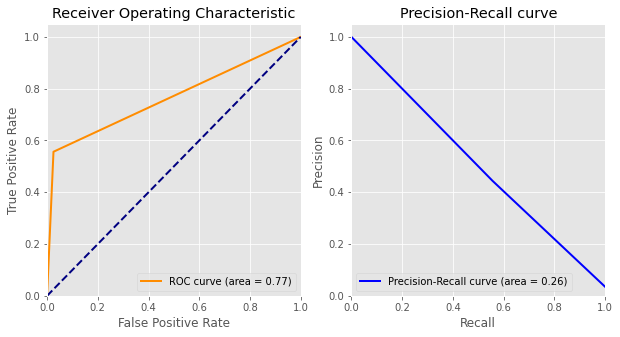

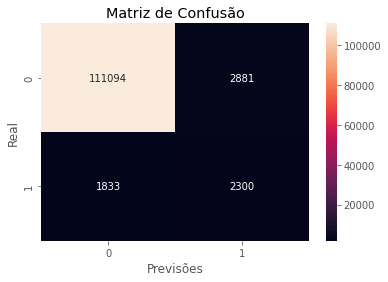

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.44      0.56      0.49      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.77      0.74    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 17s, sys: 328 ms, total: 1min 17s
Wall time: 1min 17s


In [82]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.49414545063916643
F1-Score Negativo (Teste): 0.9792470042792863
F1-Score Positivo Médio (Validação Cruzada): 0.4233231931376068
F1-Score Positivo Fold 1: 0.44697833523375147
F1-Score Positivo Fold 2: 0.41505131128848344
F1-Score Positivo Fold 3: 0.4627906976744186
F1-Score Positivo Fold 4: 0.411214953271028
F1-Score Positivo Fold 5: 0.3932203389830508
F1-Score Positivo Fold 6: 0.41834451901565994
F1-Score Positivo Fold 7: 0.40893854748603353
F1-Score Positivo Fold 8: 0.44493392070484583
F1-Score Positivo Fold 9: 0.4127332601536773
F1-Score Positivo Fold 10: 0.41902604756511896
F1-Score Negativo Médio (Validação Cruzada): 0.9775603280303814
F1-Score Negativo Fold 1: 0.9786766322268632
F1-Score Negativo Fold 2: 0.9774455924378983
F1-Score Negativo Fold 3: 0.9797030137949213
F1-Score Negativo Fold 4: 0.9778617236229465
F1-Score Negativo Fold 5: 0.9763821084575801
F1-Score Negativo Fold 6: 0.9771207321365717
F1-Score Negativo Fold 7: 0.9767237206846482
F1-Score

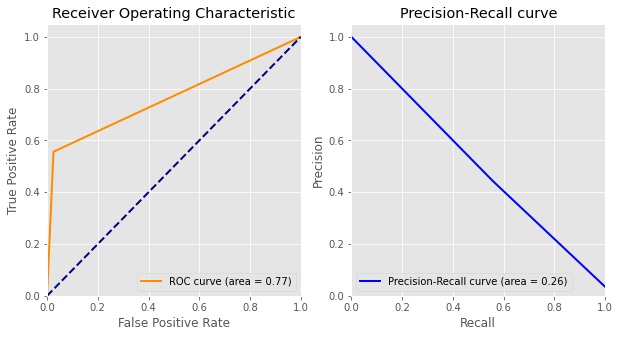

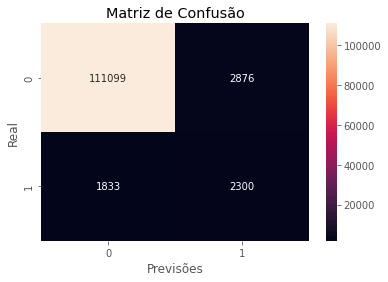

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.44      0.56      0.49      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.77      0.74    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 17s, sys: 356 ms, total: 1min 17s
Wall time: 1min 17s


In [83]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.49414545063916643
F1-Score Negativo (Teste): 0.9792470042792863
F1-Score Positivo Médio (Validação Cruzada): 0.4233231931376068
F1-Score Positivo Fold 1: 0.44697833523375147
F1-Score Positivo Fold 2: 0.41505131128848344
F1-Score Positivo Fold 3: 0.4627906976744186
F1-Score Positivo Fold 4: 0.411214953271028
F1-Score Positivo Fold 5: 0.3932203389830508
F1-Score Positivo Fold 6: 0.41834451901565994
F1-Score Positivo Fold 7: 0.40893854748603353
F1-Score Positivo Fold 8: 0.44493392070484583
F1-Score Positivo Fold 9: 0.4127332601536773
F1-Score Positivo Fold 10: 0.41902604756511896
F1-Score Negativo Médio (Validação Cruzada): 0.9775603280303814
F1-Score Negativo Fold 1: 0.9786766322268632
F1-Score Negativo Fold 2: 0.9774455924378983
F1-Score Negativo Fold 3: 0.9797030137949213
F1-Score Negativo Fold 4: 0.9778617236229465
F1-Score Negativo Fold 5: 0.9763821084575801
F1-Score Negativo Fold 6: 0.9771207321365717
F1-Score Negativo Fold 7: 0.9767237206846482
F1-Score

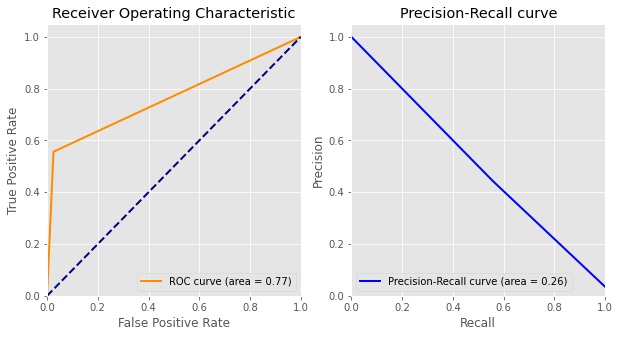

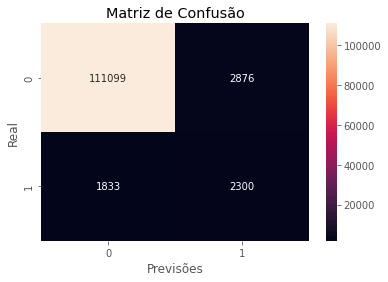

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.44      0.56      0.49      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.77      0.74    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 17s, sys: 364 ms, total: 1min 17s
Wall time: 1min 17s


In [84]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### CatBoost

0:	learn: 0.6197319	total: 123ms	remaining: 494ms
1:	learn: 0.5528627	total: 201ms	remaining: 302ms
2:	learn: 0.5110298	total: 265ms	remaining: 177ms
3:	learn: 0.4778530	total: 333ms	remaining: 83.4ms
4:	learn: 0.4468749	total: 402ms	remaining: 0us
0:	learn: 0.5389924	total: 13.3ms	remaining: 53.4ms
1:	learn: 0.4294767	total: 22.4ms	remaining: 33.6ms
2:	learn: 0.3515248	total: 29.8ms	remaining: 19.9ms
3:	learn: 0.2972794	total: 37ms	remaining: 9.24ms
4:	learn: 0.2528170	total: 44.5ms	remaining: 0us
0:	learn: 0.5388417	total: 8.04ms	remaining: 32.1ms
1:	learn: 0.4294075	total: 16.6ms	remaining: 24.9ms
2:	learn: 0.3511561	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.2968462	total: 31ms	remaining: 7.74ms
4:	learn: 0.2522807	total: 38.6ms	remaining: 0us
0:	learn: 0.5390110	total: 14.2ms	remaining: 56.7ms
1:	learn: 0.4290483	total: 23.7ms	remaining: 35.5ms
2:	learn: 0.3510693	total: 31.4ms	remaining: 21ms
3:	learn: 0.2968198	total: 38.6ms	remaining: 9.65ms
4:	learn: 0.2523715	total: 46.3ms	r

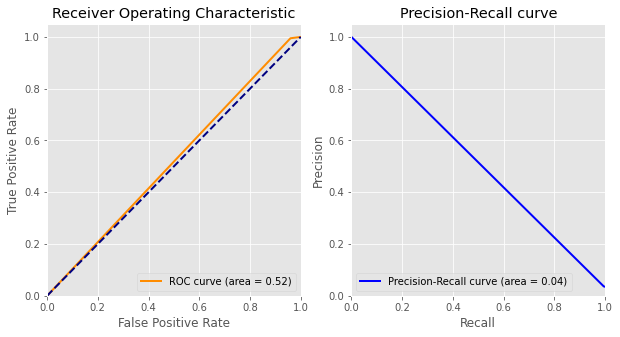

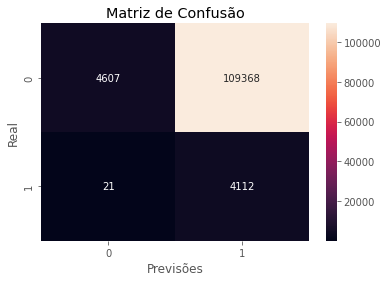

              precision    recall  f1-score   support

           0       1.00      0.04      0.08    113975
           1       0.04      0.99      0.07      4133

    accuracy                           0.07    118108
   macro avg       0.52      0.52      0.07    118108
weighted avg       0.96      0.07      0.08    118108

CPU times: user 37.9 s, sys: 907 ms, total: 38.8 s
Wall time: 21.3 s


In [85]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

0:	learn: 0.6197319	total: 67.2ms	remaining: 269ms
1:	learn: 0.5528627	total: 137ms	remaining: 205ms
2:	learn: 0.5110298	total: 204ms	remaining: 136ms
3:	learn: 0.4778530	total: 275ms	remaining: 68.7ms
4:	learn: 0.4468749	total: 343ms	remaining: 0us
0:	learn: 0.5389924	total: 7.4ms	remaining: 29.6ms
1:	learn: 0.4294767	total: 14.7ms	remaining: 22ms
2:	learn: 0.3515248	total: 21.4ms	remaining: 14.3ms
3:	learn: 0.2972794	total: 28.6ms	remaining: 7.15ms
4:	learn: 0.2528170	total: 36.1ms	remaining: 0us
0:	learn: 0.5388417	total: 7.68ms	remaining: 30.7ms
1:	learn: 0.4294075	total: 15.4ms	remaining: 23.1ms
2:	learn: 0.3511561	total: 22.4ms	remaining: 14.9ms
3:	learn: 0.2968462	total: 29.9ms	remaining: 7.47ms
4:	learn: 0.2522807	total: 37.5ms	remaining: 0us
0:	learn: 0.5390110	total: 8.23ms	remaining: 32.9ms
1:	learn: 0.4290483	total: 16.4ms	remaining: 24.7ms
2:	learn: 0.3510693	total: 24ms	remaining: 16ms
3:	learn: 0.2968198	total: 31.2ms	remaining: 7.81ms
4:	learn: 0.2523715	total: 38.8ms	r

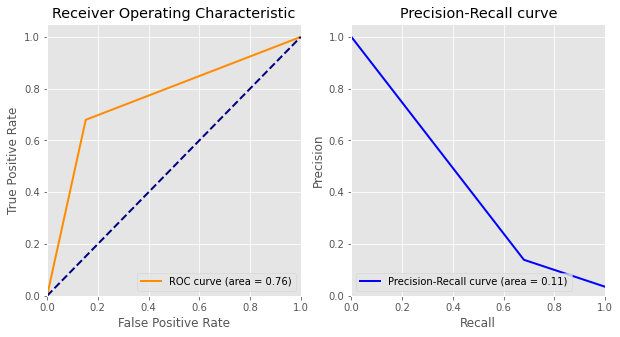

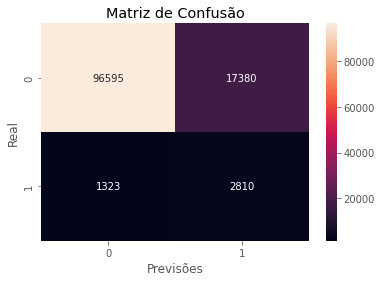

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.76      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 37.6 s, sys: 834 ms, total: 38.4 s
Wall time: 21.1 s


In [86]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

0:	learn: 0.6197319	total: 68.4ms	remaining: 274ms
1:	learn: 0.5528627	total: 138ms	remaining: 208ms
2:	learn: 0.5110298	total: 204ms	remaining: 136ms
3:	learn: 0.4778530	total: 272ms	remaining: 68ms
4:	learn: 0.4468749	total: 340ms	remaining: 0us
0:	learn: 0.5389924	total: 12.6ms	remaining: 50.4ms
1:	learn: 0.4294767	total: 21.6ms	remaining: 32.4ms
2:	learn: 0.3515248	total: 28.9ms	remaining: 19.2ms
3:	learn: 0.2972794	total: 36ms	remaining: 9ms
4:	learn: 0.2528170	total: 43.7ms	remaining: 0us
0:	learn: 0.5388417	total: 9.01ms	remaining: 36ms
1:	learn: 0.4294075	total: 18ms	remaining: 26.9ms
2:	learn: 0.3511561	total: 25.4ms	remaining: 17ms
3:	learn: 0.2968462	total: 32.6ms	remaining: 8.15ms
4:	learn: 0.2522807	total: 40.3ms	remaining: 0us
0:	learn: 0.5390110	total: 12.5ms	remaining: 50ms
1:	learn: 0.4290483	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.3510693	total: 29.3ms	remaining: 19.5ms
3:	learn: 0.2968198	total: 36.4ms	remaining: 9.09ms
4:	learn: 0.2523715	total: 44.1ms	remaining

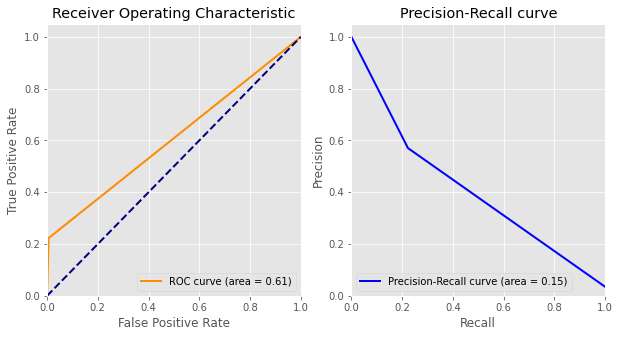

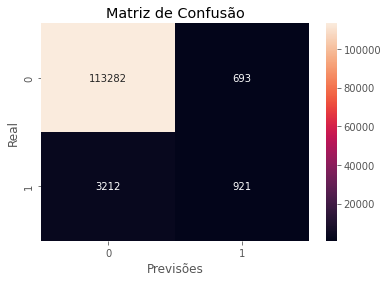

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    113975
           1       0.57      0.22      0.32      4133

    accuracy                           0.97    118108
   macro avg       0.77      0.61      0.65    118108
weighted avg       0.96      0.97      0.96    118108

CPU times: user 38 s, sys: 812 ms, total: 38.8 s
Wall time: 21.5 s


In [87]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Gradient Boosting

F1-Score Positivo (Teste): 0.1784392964881325
F1-Score Negativo (Teste): 0.8564338217010313
F1-Score Positivo Médio (Validação Cruzada): 0.31644800635415604
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.33587786259541985
F1-Score Positivo Fold 3: 0.375
F1-Score Positivo Fold 4: 0.3657142857142857
F1-Score Positivo Fold 5: 0.3452157598499062
F1-Score Positivo Fold 6: 0.35992578849721707
F1-Score Positivo Fold 7: 0.34962406015037595
F1-Score Positivo Fold 8: 0.4101633393829401
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.39552238805970147
F1-Score Negativo Médio (Validação Cruzada): 0.9845216276405291
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.9849337604987445
F1-Score Negativo Fold 3: 0.9852673541901379
F1-Score Negativo Fold 4: 0.985582543187427
F1-Score Negativo Fold 5: 0.9848845770713327
F1-Score Negativo Fold 6: 0.9850539357969069
F1-Score Negativo Fold 7: 0.9850151580770896
F1-Score Negativo Fold

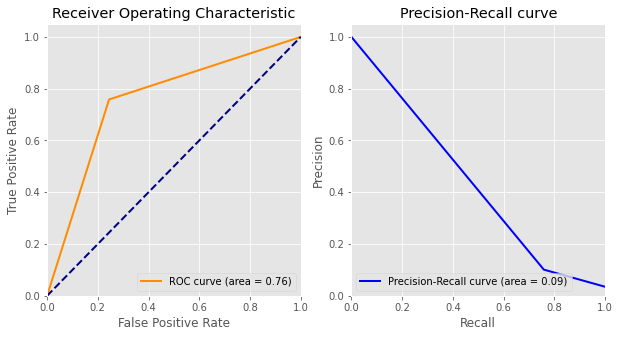

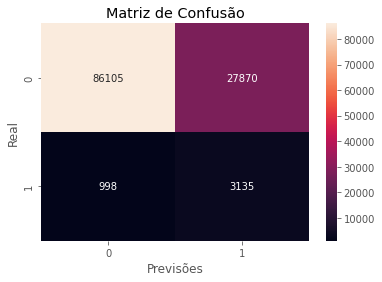

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    113975
           1       0.10      0.76      0.18      4133

    accuracy                           0.76    118108
   macro avg       0.54      0.76      0.52    118108
weighted avg       0.96      0.76      0.83    118108

CPU times: user 6min 58s, sys: 352 ms, total: 6min 58s
Wall time: 6min 58s


In [88]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3139791059626182
F1-Score Negativo (Teste): 0.9565463998739561
F1-Score Positivo Médio (Validação Cruzada): 0.31644800635415604
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.33587786259541985
F1-Score Positivo Fold 3: 0.375
F1-Score Positivo Fold 4: 0.3657142857142857
F1-Score Positivo Fold 5: 0.3452157598499062
F1-Score Positivo Fold 6: 0.35992578849721707
F1-Score Positivo Fold 7: 0.34962406015037595
F1-Score Positivo Fold 8: 0.4101633393829401
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.39552238805970147
F1-Score Negativo Médio (Validação Cruzada): 0.9845216276405291
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.9849337604987445
F1-Score Negativo Fold 3: 0.9852673541901379
F1-Score Negativo Fold 4: 0.985582543187427
F1-Score Negativo Fold 5: 0.9848845770713327
F1-Score Negativo Fold 6: 0.9850539357969069
F1-Score Negativo Fold 7: 0.9850151580770896
F1-Score Negativo Fold

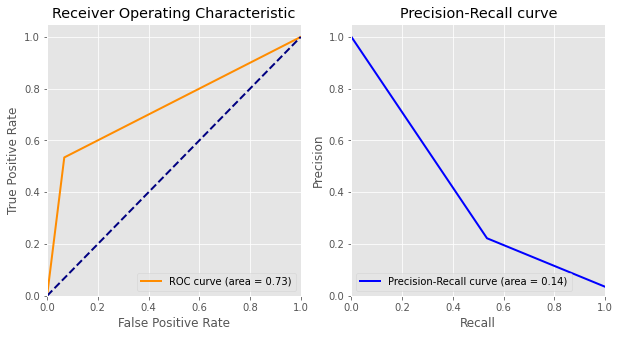

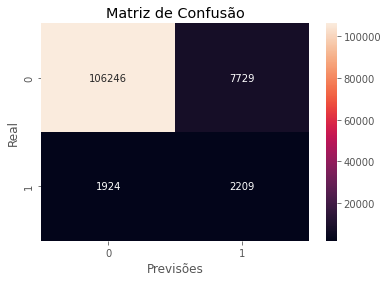

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.22      0.53      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.64    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 6min 58s, sys: 316 ms, total: 6min 58s
Wall time: 6min 58s


In [89]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.36820083682008364
F1-Score Negativo (Teste): 0.9761172521659667
F1-Score Positivo Médio (Validação Cruzada): 0.31644800635415604
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.33587786259541985
F1-Score Positivo Fold 3: 0.375
F1-Score Positivo Fold 4: 0.3657142857142857
F1-Score Positivo Fold 5: 0.3452157598499062
F1-Score Positivo Fold 6: 0.35992578849721707
F1-Score Positivo Fold 7: 0.34962406015037595
F1-Score Positivo Fold 8: 0.4101633393829401
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.39552238805970147
F1-Score Negativo Médio (Validação Cruzada): 0.9845216276405291
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.9849337604987445
F1-Score Negativo Fold 3: 0.9852673541901379
F1-Score Negativo Fold 4: 0.985582543187427
F1-Score Negativo Fold 5: 0.9848845770713327
F1-Score Negativo Fold 6: 0.9850539357969069
F1-Score Negativo Fold 7: 0.9850151580770896
F1-Score Negativo Fol

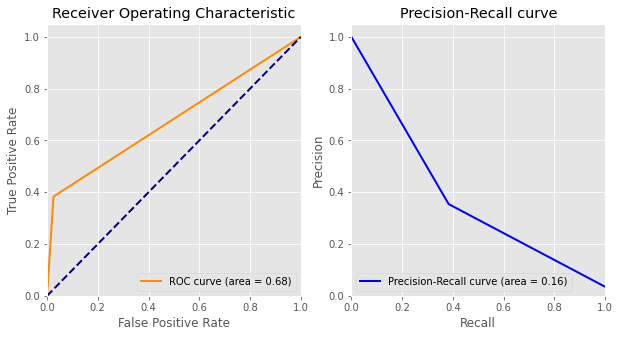

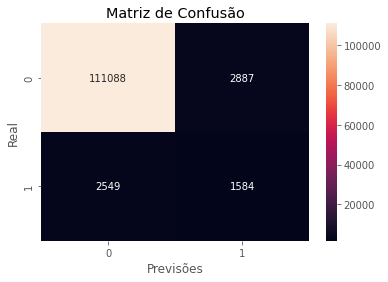

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.35      0.38      0.37      4133

    accuracy                           0.95    118108
   macro avg       0.67      0.68      0.67    118108
weighted avg       0.96      0.95      0.95    118108

CPU times: user 7min 1s, sys: 488 ms, total: 7min 2s
Wall time: 7min 1s


In [90]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### AdaBoost

F1-Score Positivo (Teste): 0.06762052012009064
F1-Score Negativo (Teste): 0.0
F1-Score Positivo Médio (Validação Cruzada): 0.33345031900871985
F1-Score Positivo Fold 1: 0.31496062992125984
F1-Score Positivo Fold 2: 0.3218390804597701
F1-Score Positivo Fold 3: 0.33020637898686683
F1-Score Positivo Fold 4: 0.3143418467583497
F1-Score Positivo Fold 5: 0.3238095238095238
F1-Score Positivo Fold 6: 0.3365200764818356
F1-Score Positivo Fold 7: 0.32149532710280376
F1-Score Positivo Fold 8: 0.3533834586466166
F1-Score Positivo Fold 9: 0.3587786259541985
F1-Score Positivo Fold 10: 0.3591682419659735
F1-Score Negativo Médio (Validação Cruzada): 0.9848815245036636
F1-Score Negativo Fold 1: 0.9849441896685992
F1-Score Negativo Fold 2: 0.9846753246753246
F1-Score Negativo Fold 3: 0.9845380917319936
F1-Score Negativo Fold 4: 0.9849002725738761
F1-Score Negativo Fold 5: 0.9846300385331428
F1-Score Negativo Fold 6: 0.9849777046625394
F1-Score Negativo Fold 7: 0.9842768657686144
F1-Score Negativo Fold 8

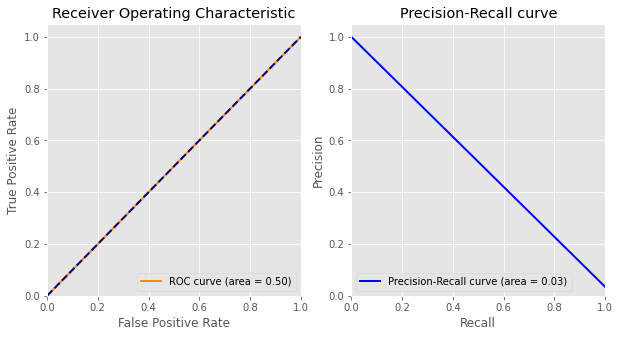

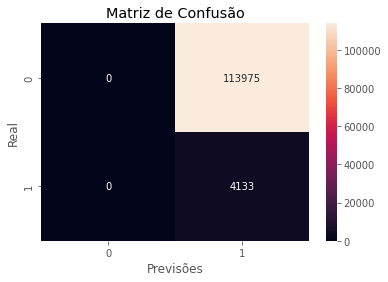

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    113975
           1       0.03      1.00      0.07      4133

    accuracy                           0.03    118108
   macro avg       0.02      0.50      0.03    118108
weighted avg       0.00      0.03      0.00    118108

CPU times: user 8min 14s, sys: 4.42 s, total: 8min 19s
Wall time: 8min 18s


In [91]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3049321236100689
F1-Score Negativo (Teste): 0.9540118344263553
F1-Score Positivo Médio (Validação Cruzada): 0.33345031900871985
F1-Score Positivo Fold 1: 0.31496062992125984
F1-Score Positivo Fold 2: 0.3218390804597701
F1-Score Positivo Fold 3: 0.33020637898686683
F1-Score Positivo Fold 4: 0.3143418467583497
F1-Score Positivo Fold 5: 0.3238095238095238
F1-Score Positivo Fold 6: 0.3365200764818356
F1-Score Positivo Fold 7: 0.32149532710280376
F1-Score Positivo Fold 8: 0.3533834586466166
F1-Score Positivo Fold 9: 0.3587786259541985
F1-Score Positivo Fold 10: 0.3591682419659735
F1-Score Negativo Médio (Validação Cruzada): 0.9848815245036636
F1-Score Negativo Fold 1: 0.9849441896685992
F1-Score Negativo Fold 2: 0.9846753246753246
F1-Score Negativo Fold 3: 0.9845380917319936
F1-Score Negativo Fold 4: 0.9849002725738761
F1-Score Negativo Fold 5: 0.9846300385331428
F1-Score Negativo Fold 6: 0.9849777046625394
F1-Score Negativo Fold 7: 0.9842768657686144
F1-Score N

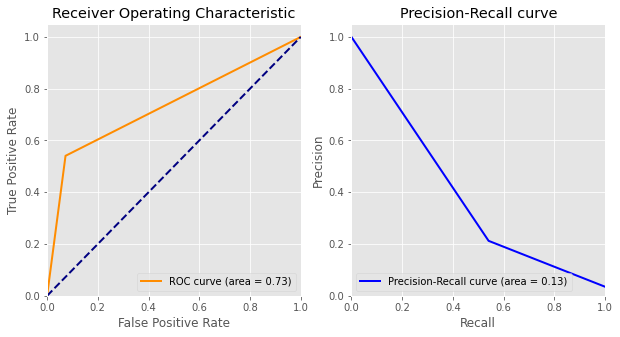

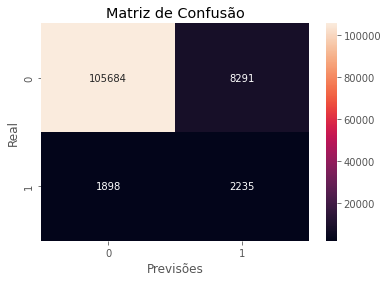

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.21      0.54      0.30      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 8min 14s, sys: 4.43 s, total: 8min 19s
Wall time: 8min 18s


In [92]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.0
F1-Score Negativo (Teste): 0.9821917158947445
F1-Score Positivo Médio (Validação Cruzada): 0.33345031900871985
F1-Score Positivo Fold 1: 0.31496062992125984
F1-Score Positivo Fold 2: 0.3218390804597701
F1-Score Positivo Fold 3: 0.33020637898686683
F1-Score Positivo Fold 4: 0.3143418467583497
F1-Score Positivo Fold 5: 0.3238095238095238
F1-Score Positivo Fold 6: 0.3365200764818356
F1-Score Positivo Fold 7: 0.32149532710280376
F1-Score Positivo Fold 8: 0.3533834586466166
F1-Score Positivo Fold 9: 0.3587786259541985
F1-Score Positivo Fold 10: 0.3591682419659735
F1-Score Negativo Médio (Validação Cruzada): 0.9848815245036636
F1-Score Negativo Fold 1: 0.9849441896685992
F1-Score Negativo Fold 2: 0.9846753246753246
F1-Score Negativo Fold 3: 0.9845380917319936
F1-Score Negativo Fold 4: 0.9849002725738761
F1-Score Negativo Fold 5: 0.9846300385331428
F1-Score Negativo Fold 6: 0.9849777046625394
F1-Score Negativo Fold 7: 0.9842768657686144
F1-Score Negativo Fold 8:

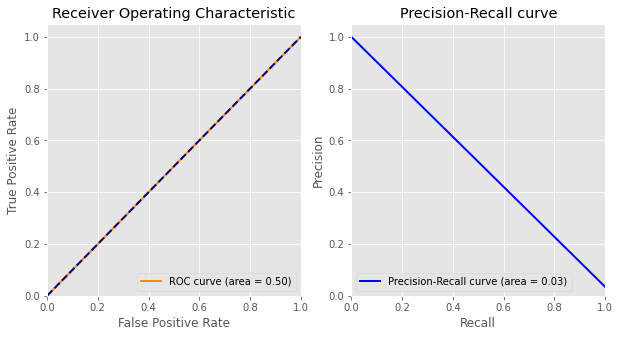

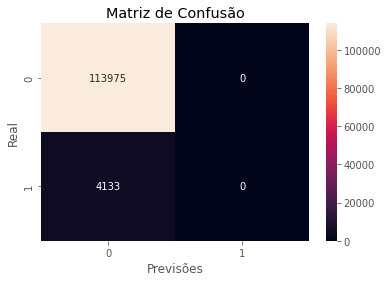

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.00      0.00      0.00      4133

    accuracy                           0.97    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.97      0.95    118108

CPU times: user 8min 10s, sys: 3.78 s, total: 8min 14s
Wall time: 8min 13s


In [93]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### KNN

F1-Score Positivo (Teste): 0.26799349721661164
F1-Score Negativo (Teste): 0.9311818893371063
F1-Score Positivo Médio (Validação Cruzada): 0.2596242535596863
F1-Score Positivo Fold 1: 0.23362831858407082
F1-Score Positivo Fold 2: 0.288135593220339
F1-Score Positivo Fold 3: 0.26970227670753066
F1-Score Positivo Fold 4: 0.2402707275803722
F1-Score Positivo Fold 5: 0.24347826086956523
F1-Score Positivo Fold 6: 0.24822695035460995
F1-Score Positivo Fold 7: 0.2732049036777583
F1-Score Positivo Fold 8: 0.23711340206185566
F1-Score Positivo Fold 9: 0.2822719449225473
F1-Score Positivo Fold 10: 0.28021015761821366
F1-Score Negativo Médio (Validação Cruzada): 0.9814930574608312
F1-Score Negativo Fold 1: 0.981220453658325
F1-Score Negativo Fold 2: 0.9817645015630426
F1-Score Negativo Fold 3: 0.981909678538892
F1-Score Negativo Fold 4: 0.9805045373626851
F1-Score Negativo Fold 5: 0.9811255260988415
F1-Score Negativo Fold 6: 0.9816115881689652
F1-Score Negativo Fold 7: 0.9819964426706
F1-Score Nega

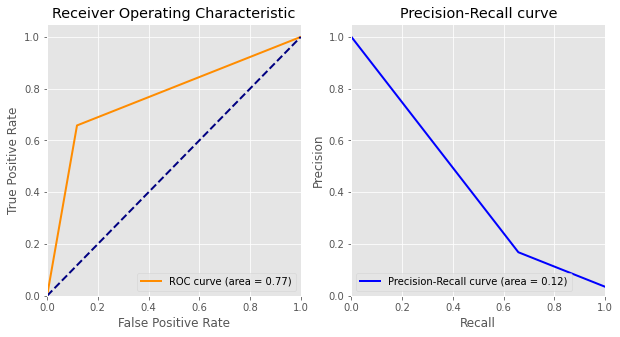

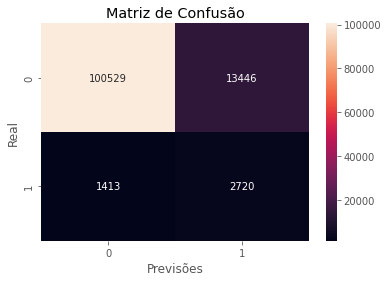

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113975
           1       0.17      0.66      0.27      4133

    accuracy                           0.87    118108
   macro avg       0.58      0.77      0.60    118108
weighted avg       0.96      0.87      0.91    118108

CPU times: user 22min 11s, sys: 719 ms, total: 22min 11s
Wall time: 1min 58s


In [94]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.32383748081926744
F1-Score Negativo (Teste): 0.9541873279482161
F1-Score Positivo Médio (Validação Cruzada): 0.2596242535596863
F1-Score Positivo Fold 1: 0.23362831858407082
F1-Score Positivo Fold 2: 0.288135593220339
F1-Score Positivo Fold 3: 0.26970227670753066
F1-Score Positivo Fold 4: 0.2402707275803722
F1-Score Positivo Fold 5: 0.24347826086956523
F1-Score Positivo Fold 6: 0.24822695035460995
F1-Score Positivo Fold 7: 0.2732049036777583
F1-Score Positivo Fold 8: 0.23711340206185566
F1-Score Positivo Fold 9: 0.2822719449225473
F1-Score Positivo Fold 10: 0.28021015761821366
F1-Score Negativo Médio (Validação Cruzada): 0.9814930574608312
F1-Score Negativo Fold 1: 0.981220453658325
F1-Score Negativo Fold 2: 0.9817645015630426
F1-Score Negativo Fold 3: 0.981909678538892
F1-Score Negativo Fold 4: 0.9805045373626851
F1-Score Negativo Fold 5: 0.9811255260988415
F1-Score Negativo Fold 6: 0.9816115881689652
F1-Score Negativo Fold 7: 0.9819964426706
F1-Score Nega

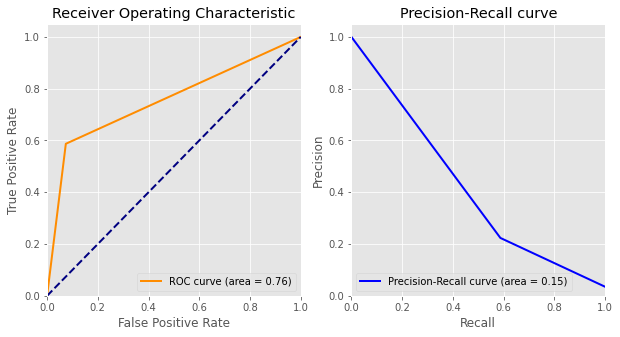

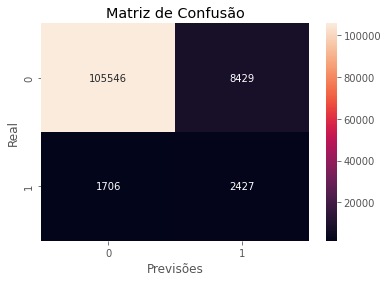

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 23min 2s, sys: 919 ms, total: 23min 3s
Wall time: 2min 2s


In [95]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.40128153784541454
F1-Score Negativo (Teste): 0.9735664904432697
F1-Score Positivo Médio (Validação Cruzada): 0.2596242535596863
F1-Score Positivo Fold 1: 0.23362831858407082
F1-Score Positivo Fold 2: 0.288135593220339
F1-Score Positivo Fold 3: 0.26970227670753066
F1-Score Positivo Fold 4: 0.2402707275803722
F1-Score Positivo Fold 5: 0.24347826086956523
F1-Score Positivo Fold 6: 0.24822695035460995
F1-Score Positivo Fold 7: 0.2732049036777583
F1-Score Positivo Fold 8: 0.23711340206185566
F1-Score Positivo Fold 9: 0.2822719449225473
F1-Score Positivo Fold 10: 0.28021015761821366
F1-Score Negativo Médio (Validação Cruzada): 0.9814930574608312
F1-Score Negativo Fold 1: 0.981220453658325
F1-Score Negativo Fold 2: 0.9817645015630426
F1-Score Negativo Fold 3: 0.981909678538892
F1-Score Negativo Fold 4: 0.9805045373626851
F1-Score Negativo Fold 5: 0.9811255260988415
F1-Score Negativo Fold 6: 0.9816115881689652
F1-Score Negativo Fold 7: 0.9819964426706
F1-Score Nega

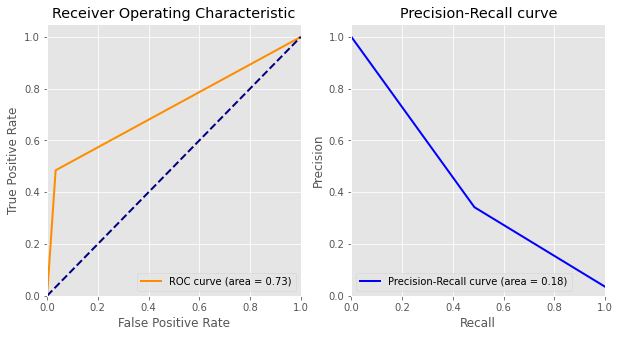

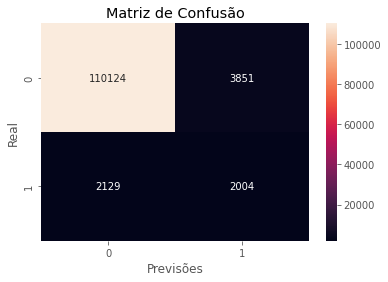

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    113975
           1       0.34      0.48      0.40      4133

    accuracy                           0.95    118108
   macro avg       0.66      0.73      0.69    118108
weighted avg       0.96      0.95      0.95    118108

CPU times: user 23min 3s, sys: 780 ms, total: 23min 3s
Wall time: 2min 2s


In [96]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_75_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test[oversample_with_smote_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

### Todas as colunas

In [97]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

#### Extra Trees

F1-Score Positivo (Teste): 0.6532036371325862
F1-Score Negativo (Teste): 0.9855352402120323
F1-Score Positivo Médio (Validação Cruzada): 0.4955340210408693
F1-Score Positivo Fold 1: 0.5088967971530249
F1-Score Positivo Fold 2: 0.4756944444444444
F1-Score Positivo Fold 3: 0.49554367201426025
F1-Score Positivo Fold 4: 0.4548736462093863
F1-Score Positivo Fold 5: 0.47311827956989244
F1-Score Positivo Fold 6: 0.4964539007092199
F1-Score Positivo Fold 7: 0.5078809106830123
F1-Score Positivo Fold 8: 0.5053003533568905
F1-Score Positivo Fold 9: 0.534923339011925
F1-Score Positivo Fold 10: 0.5026548672566372
F1-Score Negativo Médio (Validação Cruzada): 0.9876124052494865
F1-Score Negativo Fold 1: 0.9880312228967909
F1-Score Negativo Fold 2: 0.9868957736700512
F1-Score Negativo Fold 3: 0.9877281991240622
F1-Score Negativo Fold 4: 0.9869082711981966
F1-Score Negativo Fold 5: 0.9872528616024975
F1-Score Negativo Fold 6: 0.987683233584873
F1-Score Negativo Fold 7: 0.9878096394950329
F1-Score Negat

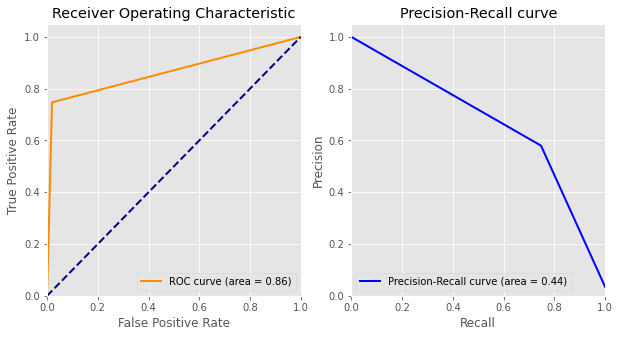

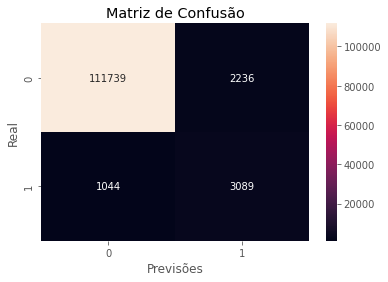

              precision    recall  f1-score   support

           0       0.99      0.98      0.99    113975
           1       0.58      0.75      0.65      4133

    accuracy                           0.97    118108
   macro avg       0.79      0.86      0.82    118108
weighted avg       0.98      0.97      0.97    118108

CPU times: user 8min 51s, sys: 361 ms, total: 8min 51s
Wall time: 8min 51s


In [98]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.6750037667620913
F1-Score Negativo (Teste): 0.9906045413561345
F1-Score Positivo Médio (Validação Cruzada): 0.4955340210408693
F1-Score Positivo Fold 1: 0.5088967971530249
F1-Score Positivo Fold 2: 0.4756944444444444
F1-Score Positivo Fold 3: 0.49554367201426025
F1-Score Positivo Fold 4: 0.4548736462093863
F1-Score Positivo Fold 5: 0.47311827956989244
F1-Score Positivo Fold 6: 0.4964539007092199
F1-Score Positivo Fold 7: 0.5078809106830123
F1-Score Positivo Fold 8: 0.5053003533568905
F1-Score Positivo Fold 9: 0.534923339011925
F1-Score Positivo Fold 10: 0.5026548672566372
F1-Score Negativo Médio (Validação Cruzada): 0.9876124052494865
F1-Score Negativo Fold 1: 0.9880312228967909
F1-Score Negativo Fold 2: 0.9868957736700512
F1-Score Negativo Fold 3: 0.9877281991240622
F1-Score Negativo Fold 4: 0.9869082711981966
F1-Score Negativo Fold 5: 0.9872528616024975
F1-Score Negativo Fold 6: 0.987683233584873
F1-Score Negativo Fold 7: 0.9878096394950329
F1-Score Negat

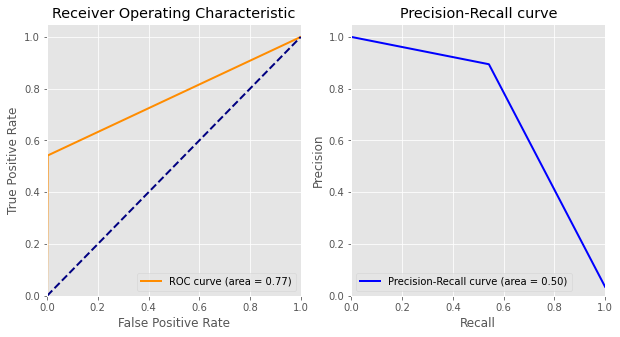

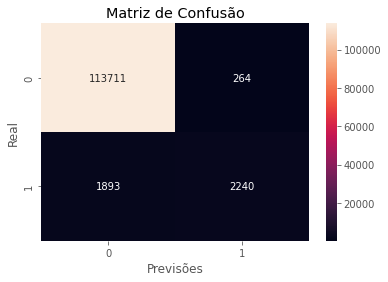

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.54      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 51s, sys: 365 ms, total: 8min 51s
Wall time: 8min 51s


In [99]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.5500173070266527
F1-Score Negativo (Teste): 0.9887171386663658
F1-Score Positivo Médio (Validação Cruzada): 0.4955340210408693
F1-Score Positivo Fold 1: 0.5088967971530249
F1-Score Positivo Fold 2: 0.4756944444444444
F1-Score Positivo Fold 3: 0.49554367201426025
F1-Score Positivo Fold 4: 0.4548736462093863
F1-Score Positivo Fold 5: 0.47311827956989244
F1-Score Positivo Fold 6: 0.4964539007092199
F1-Score Positivo Fold 7: 0.5078809106830123
F1-Score Positivo Fold 8: 0.5053003533568905
F1-Score Positivo Fold 9: 0.534923339011925
F1-Score Positivo Fold 10: 0.5026548672566372
F1-Score Negativo Médio (Validação Cruzada): 0.9876124052494865
F1-Score Negativo Fold 1: 0.9880312228967909
F1-Score Negativo Fold 2: 0.9868957736700512
F1-Score Negativo Fold 3: 0.9877281991240622
F1-Score Negativo Fold 4: 0.9869082711981966
F1-Score Negativo Fold 5: 0.9872528616024975
F1-Score Negativo Fold 6: 0.987683233584873
F1-Score Negativo Fold 7: 0.9878096394950329
F1-Score Negat

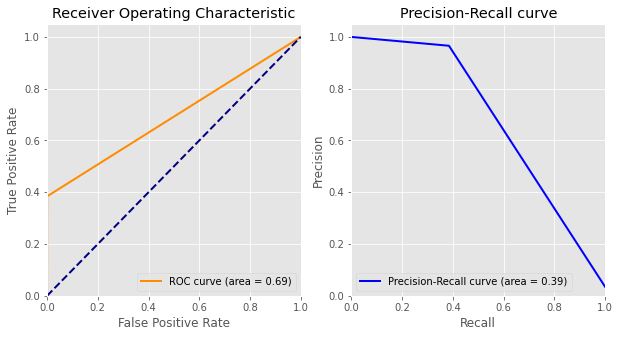

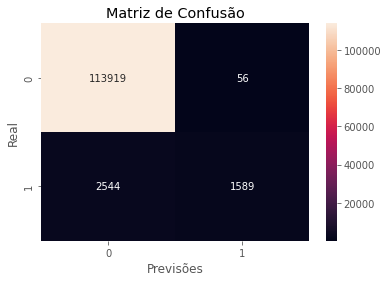

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.97      0.38      0.55      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.69      0.77    118108
weighted avg       0.98      0.98      0.97    118108

CPU times: user 8min 54s, sys: 397 ms, total: 8min 54s
Wall time: 8min 54s


In [100]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Decision Tree

F1-Score Positivo (Teste): 0.48123427070795494
F1-Score Negativo (Teste): 0.9791216195387468
F1-Score Positivo Médio (Validação Cruzada): 0.4294050339647494
F1-Score Positivo Fold 1: 0.4574095682613769
F1-Score Positivo Fold 2: 0.42528735632183906
F1-Score Positivo Fold 3: 0.4532130777903044
F1-Score Positivo Fold 4: 0.39588100686498856
F1-Score Positivo Fold 5: 0.4041811846689896
F1-Score Positivo Fold 6: 0.43381535038932145
F1-Score Positivo Fold 7: 0.4148816234498309
F1-Score Positivo Fold 8: 0.447427293064877
F1-Score Positivo Fold 9: 0.42824601366742593
F1-Score Positivo Fold 10: 0.4337078651685393
F1-Score Negativo Médio (Validação Cruzada): 0.9779304896371551
F1-Score Negativo Fold 1: 0.979573907313859
F1-Score Negativo Fold 2: 0.9780239099859352
F1-Score Negativo Fold 3: 0.9786672531339344
F1-Score Negativo Fold 4: 0.97678916827853
F1-Score Negativo Fold 5: 0.977461447212337
F1-Score Negativo Fold 6: 0.977599788760287
F1-Score Negativo Fold 7: 0.9771717616010557
F1-Score Negati

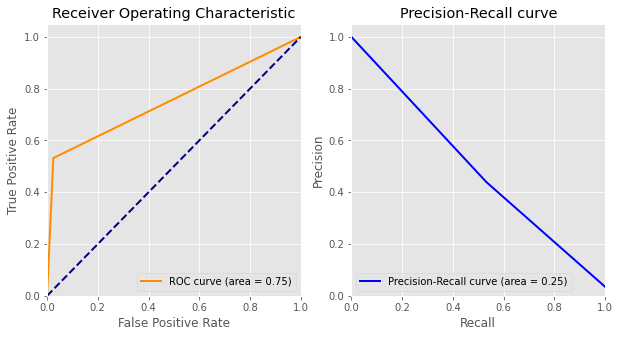

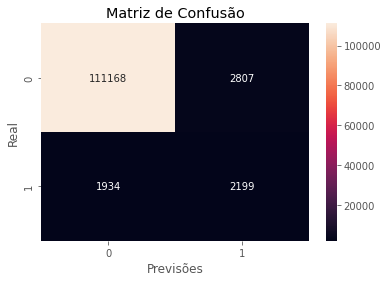

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.44      0.53      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 58s, sys: 348 ms, total: 1min 59s
Wall time: 1min 58s


In [101]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.4812869336835194
F1-Score Negativo (Teste): 0.9791261152555509
F1-Score Positivo Médio (Validação Cruzada): 0.4294050339647494
F1-Score Positivo Fold 1: 0.4574095682613769
F1-Score Positivo Fold 2: 0.42528735632183906
F1-Score Positivo Fold 3: 0.4532130777903044
F1-Score Positivo Fold 4: 0.39588100686498856
F1-Score Positivo Fold 5: 0.4041811846689896
F1-Score Positivo Fold 6: 0.43381535038932145
F1-Score Positivo Fold 7: 0.4148816234498309
F1-Score Positivo Fold 8: 0.447427293064877
F1-Score Positivo Fold 9: 0.42824601366742593
F1-Score Positivo Fold 10: 0.4337078651685393
F1-Score Negativo Médio (Validação Cruzada): 0.9779304896371551
F1-Score Negativo Fold 1: 0.979573907313859
F1-Score Negativo Fold 2: 0.9780239099859352
F1-Score Negativo Fold 3: 0.9786672531339344
F1-Score Negativo Fold 4: 0.97678916827853
F1-Score Negativo Fold 5: 0.977461447212337
F1-Score Negativo Fold 6: 0.977599788760287
F1-Score Negativo Fold 7: 0.9771717616010557
F1-Score Negativ

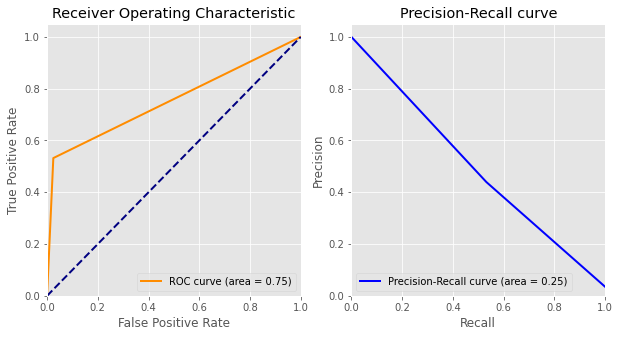

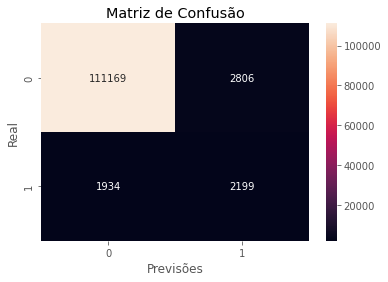

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.44      0.53      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 58s, sys: 308 ms, total: 1min 58s
Wall time: 1min 58s


In [102]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.4812869336835194
F1-Score Negativo (Teste): 0.9791261152555509
F1-Score Positivo Médio (Validação Cruzada): 0.4294050339647494
F1-Score Positivo Fold 1: 0.4574095682613769
F1-Score Positivo Fold 2: 0.42528735632183906
F1-Score Positivo Fold 3: 0.4532130777903044
F1-Score Positivo Fold 4: 0.39588100686498856
F1-Score Positivo Fold 5: 0.4041811846689896
F1-Score Positivo Fold 6: 0.43381535038932145
F1-Score Positivo Fold 7: 0.4148816234498309
F1-Score Positivo Fold 8: 0.447427293064877
F1-Score Positivo Fold 9: 0.42824601366742593
F1-Score Positivo Fold 10: 0.4337078651685393
F1-Score Negativo Médio (Validação Cruzada): 0.9779304896371551
F1-Score Negativo Fold 1: 0.979573907313859
F1-Score Negativo Fold 2: 0.9780239099859352
F1-Score Negativo Fold 3: 0.9786672531339344
F1-Score Negativo Fold 4: 0.97678916827853
F1-Score Negativo Fold 5: 0.977461447212337
F1-Score Negativo Fold 6: 0.977599788760287
F1-Score Negativo Fold 7: 0.9771717616010557
F1-Score Negativ

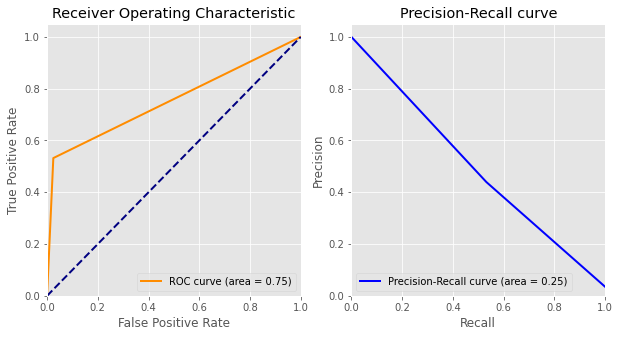

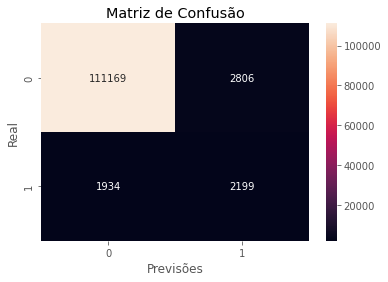

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.44      0.53      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 58s, sys: 316 ms, total: 1min 59s
Wall time: 1min 58s


In [103]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### CatBoost

0:	learn: 0.6057922	total: 77ms	remaining: 308ms
1:	learn: 0.5400358	total: 153ms	remaining: 230ms
2:	learn: 0.4834998	total: 226ms	remaining: 151ms
3:	learn: 0.4519096	total: 299ms	remaining: 74.8ms
4:	learn: 0.4196478	total: 373ms	remaining: 0us
0:	learn: 0.5334432	total: 12.6ms	remaining: 50.5ms
1:	learn: 0.4269824	total: 22.6ms	remaining: 33.8ms
2:	learn: 0.3418370	total: 31.1ms	remaining: 20.8ms
3:	learn: 0.2889428	total: 39.1ms	remaining: 9.77ms
4:	learn: 0.2438227	total: 47.7ms	remaining: 0us
0:	learn: 0.5328883	total: 8.03ms	remaining: 32.1ms
1:	learn: 0.4261596	total: 16.6ms	remaining: 24.8ms
2:	learn: 0.3402021	total: 25ms	remaining: 16.7ms
3:	learn: 0.2873771	total: 32.8ms	remaining: 8.2ms
4:	learn: 0.2424056	total: 41.4ms	remaining: 0us
0:	learn: 0.5334591	total: 8.01ms	remaining: 32ms
1:	learn: 0.4267209	total: 16.4ms	remaining: 24.6ms
2:	learn: 0.3408220	total: 24.7ms	remaining: 16.5ms
3:	learn: 0.2879136	total: 33.1ms	remaining: 8.27ms
4:	learn: 0.2437704	total: 41.5ms	r

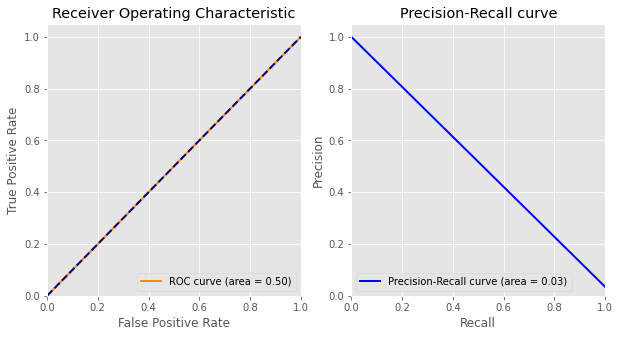

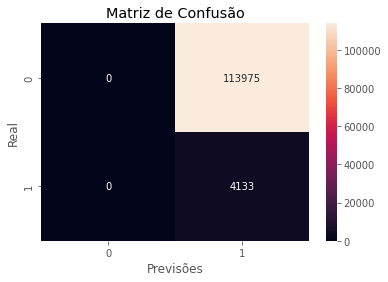

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    113975
           1       0.03      1.00      0.07      4133

    accuracy                           0.03    118108
   macro avg       0.02      0.50      0.03    118108
weighted avg       0.00      0.03      0.00    118108

CPU times: user 1min 49s, sys: 902 ms, total: 1min 50s
Wall time: 1min 24s


In [104]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

0:	learn: 0.6057922	total: 93.2ms	remaining: 373ms
1:	learn: 0.5400358	total: 169ms	remaining: 253ms
2:	learn: 0.4834998	total: 242ms	remaining: 162ms
3:	learn: 0.4519096	total: 315ms	remaining: 78.7ms
4:	learn: 0.4196478	total: 389ms	remaining: 0us
0:	learn: 0.5334432	total: 15ms	remaining: 59.8ms
1:	learn: 0.4269824	total: 26ms	remaining: 39ms
2:	learn: 0.3418370	total: 34.9ms	remaining: 23.2ms
3:	learn: 0.2889428	total: 42.6ms	remaining: 10.7ms
4:	learn: 0.2438227	total: 51.1ms	remaining: 0us
0:	learn: 0.5328883	total: 8.7ms	remaining: 34.8ms
1:	learn: 0.4261596	total: 17.4ms	remaining: 26.1ms
2:	learn: 0.3402021	total: 25.6ms	remaining: 17.1ms
3:	learn: 0.2873771	total: 33.5ms	remaining: 8.37ms
4:	learn: 0.2424056	total: 42.1ms	remaining: 0us
0:	learn: 0.5334591	total: 12.6ms	remaining: 50.5ms
1:	learn: 0.4267209	total: 22.3ms	remaining: 33.4ms
2:	learn: 0.3408220	total: 30.8ms	remaining: 20.5ms
3:	learn: 0.2879136	total: 38.9ms	remaining: 9.72ms
4:	learn: 0.2437704	total: 47.5ms	r

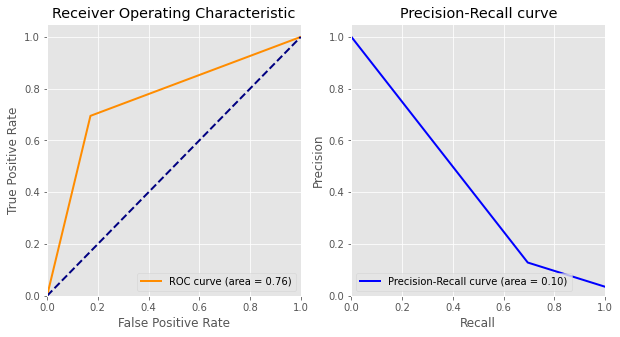

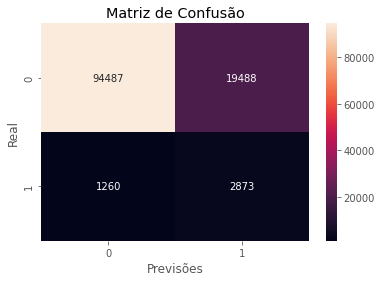

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.13      0.70      0.22      4133

    accuracy                           0.82    118108
   macro avg       0.56      0.76      0.56    118108
weighted avg       0.96      0.82      0.88    118108

CPU times: user 1min 49s, sys: 874 ms, total: 1min 50s
Wall time: 1min 24s


In [105]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

0:	learn: 0.6057922	total: 77.9ms	remaining: 312ms
1:	learn: 0.5400358	total: 153ms	remaining: 230ms
2:	learn: 0.4834998	total: 228ms	remaining: 152ms
3:	learn: 0.4519096	total: 300ms	remaining: 75ms
4:	learn: 0.4196478	total: 373ms	remaining: 0us
0:	learn: 0.5334432	total: 12.7ms	remaining: 50.7ms
1:	learn: 0.4269824	total: 22.3ms	remaining: 33.5ms
2:	learn: 0.3418370	total: 30.8ms	remaining: 20.5ms
3:	learn: 0.2889428	total: 38.7ms	remaining: 9.67ms
4:	learn: 0.2438227	total: 47.6ms	remaining: 0us
0:	learn: 0.5328883	total: 9.31ms	remaining: 37.2ms
1:	learn: 0.4261596	total: 19.5ms	remaining: 29.2ms
2:	learn: 0.3402021	total: 28ms	remaining: 18.7ms
3:	learn: 0.2873771	total: 36.3ms	remaining: 9.06ms
4:	learn: 0.2424056	total: 44.9ms	remaining: 0us
0:	learn: 0.5334591	total: 7.82ms	remaining: 31.3ms
1:	learn: 0.4267209	total: 16.1ms	remaining: 24.2ms
2:	learn: 0.3408220	total: 24.7ms	remaining: 16.5ms
3:	learn: 0.2879136	total: 33.4ms	remaining: 8.36ms
4:	learn: 0.2437704	total: 41.9m

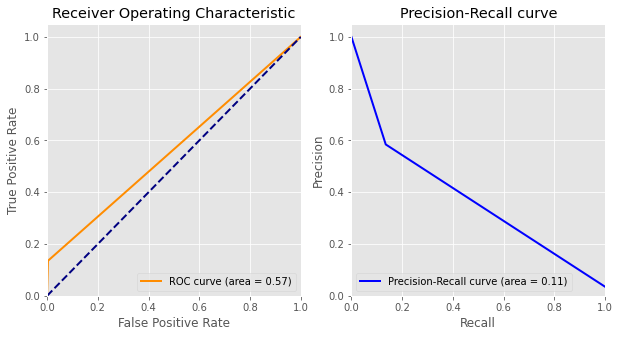

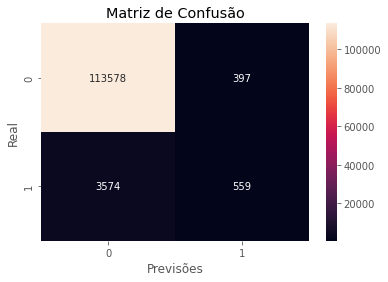

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.58      0.14      0.22      4133

    accuracy                           0.97    118108
   macro avg       0.78      0.57      0.60    118108
weighted avg       0.96      0.97      0.96    118108

CPU times: user 1min 48s, sys: 651 ms, total: 1min 49s
Wall time: 1min 24s


In [106]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Gradient Boosting

F1-Score Positivo (Teste): 0.1930149406206104
F1-Score Negativo (Teste): 0.8766276867813287
F1-Score Positivo Médio (Validação Cruzada): 0.27074190825096744
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.26877470355731226
F1-Score Positivo Fold 3: 0.2879684418145957
F1-Score Positivo Fold 4: 0.3294117647058824
F1-Score Positivo Fold 5: 0.2912621359223301
F1-Score Positivo Fold 6: 0.23340040241448695
F1-Score Positivo Fold 7: 0.3017408123791102
F1-Score Positivo Fold 8: 0.3674242424242425
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.4
F1-Score Negativo Médio (Validação Cruzada): 0.9839783452934106
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.9839937705485378
F1-Score Negativo Fold 3: 0.9843824356478477
F1-Score Negativo Fold 4: 0.985202492211838
F1-Score Negativo Fold 5: 0.9842039208897735
F1-Score Negativo Fold 6: 0.9835243243243244
F1-Score Negativo Fold 7: 0.9843756762605496
F1-Score Negativo Fold 8: 

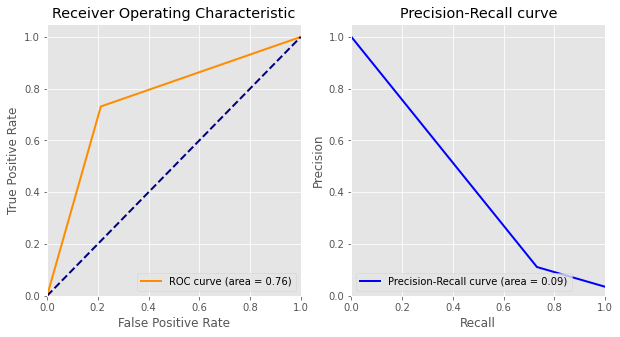

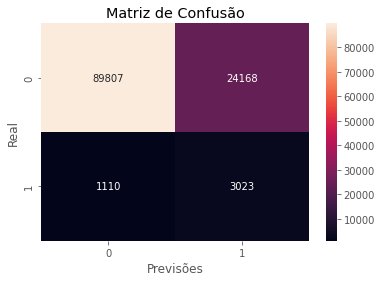

              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113975
           1       0.11      0.73      0.19      4133

    accuracy                           0.79    118108
   macro avg       0.55      0.76      0.53    118108
weighted avg       0.96      0.79      0.85    118108

CPU times: user 9min 12s, sys: 445 ms, total: 9min 13s
Wall time: 9min 12s


In [107]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3295090923281043
F1-Score Negativo (Teste): 0.9615448315376247
F1-Score Positivo Médio (Validação Cruzada): 0.27074190825096744
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.26877470355731226
F1-Score Positivo Fold 3: 0.2879684418145957
F1-Score Positivo Fold 4: 0.3294117647058824
F1-Score Positivo Fold 5: 0.2912621359223301
F1-Score Positivo Fold 6: 0.23340040241448695
F1-Score Positivo Fold 7: 0.3017408123791102
F1-Score Positivo Fold 8: 0.3674242424242425
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.4
F1-Score Negativo Médio (Validação Cruzada): 0.9839783452934106
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.9839937705485378
F1-Score Negativo Fold 3: 0.9843824356478477
F1-Score Negativo Fold 4: 0.985202492211838
F1-Score Negativo Fold 5: 0.9842039208897735
F1-Score Negativo Fold 6: 0.9835243243243244
F1-Score Negativo Fold 7: 0.9843756762605496
F1-Score Negativo Fold 8: 

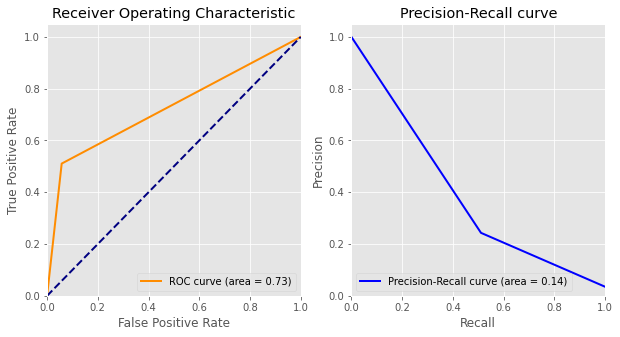

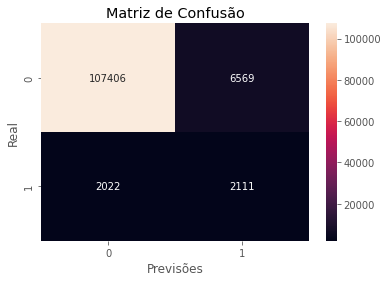

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.51      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.73      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 9min 14s, sys: 365 ms, total: 9min 14s
Wall time: 9min 14s


In [108]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3615526802218114
F1-Score Negativo (Teste): 0.9772863775257452
F1-Score Positivo Médio (Validação Cruzada): 0.27074190825096744
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.26877470355731226
F1-Score Positivo Fold 3: 0.2879684418145957
F1-Score Positivo Fold 4: 0.3294117647058824
F1-Score Positivo Fold 5: 0.2912621359223301
F1-Score Positivo Fold 6: 0.23340040241448695
F1-Score Positivo Fold 7: 0.3017408123791102
F1-Score Positivo Fold 8: 0.3674242424242425
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.4
F1-Score Negativo Médio (Validação Cruzada): 0.9839783452934106
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.9839937705485378
F1-Score Negativo Fold 3: 0.9843824356478477
F1-Score Negativo Fold 4: 0.985202492211838
F1-Score Negativo Fold 5: 0.9842039208897735
F1-Score Negativo Fold 6: 0.9835243243243244
F1-Score Negativo Fold 7: 0.9843756762605496
F1-Score Negativo Fold 8: 

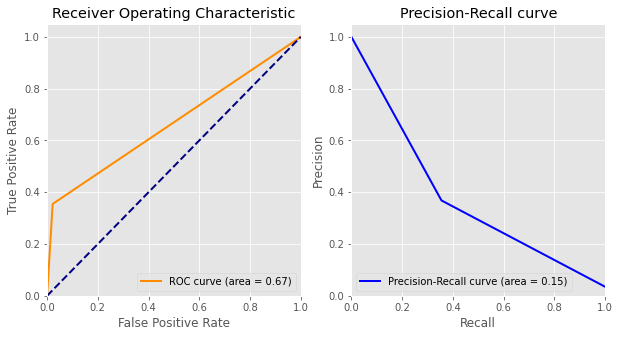

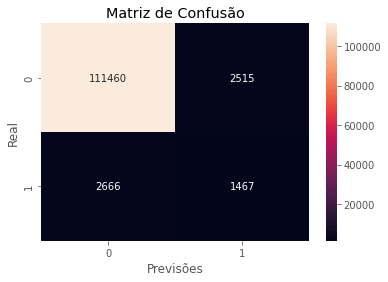

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.37      0.35      0.36      4133

    accuracy                           0.96    118108
   macro avg       0.67      0.67      0.67    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 9min 14s, sys: 381 ms, total: 9min 14s
Wall time: 9min 14s


In [109]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### AdaBoost

F1-Score Positivo (Teste): 0.06762052012009064
F1-Score Negativo (Teste): 0.0
F1-Score Positivo Médio (Validação Cruzada): 0.34266894920538027
F1-Score Positivo Fold 1: 0.35452793834296725
F1-Score Positivo Fold 2: 0.3147792706333973
F1-Score Positivo Fold 3: 0.3288718929254302
F1-Score Positivo Fold 4: 0.332688588007737
F1-Score Positivo Fold 5: 0.31800766283524906
F1-Score Positivo Fold 6: 0.3339731285988483
F1-Score Positivo Fold 7: 0.34146341463414637
F1-Score Positivo Fold 8: 0.37037037037037035
F1-Score Positivo Fold 9: 0.3639774859287055
F1-Score Positivo Fold 10: 0.36802973977695164
F1-Score Negativo Médio (Validação Cruzada): 0.985014047822278
F1-Score Negativo Fold 1: 0.9854997186512574
F1-Score Negativo Fold 2: 0.9845461235444353
F1-Score Negativo Fold 3: 0.9848045369929436
F1-Score Negativo Fold 4: 0.9850681670634063
F1-Score Negativo Fold 5: 0.9845887445887445
F1-Score Negativo Fold 6: 0.9849790052378685
F1-Score Negativo Fold 7: 0.9847979557364979
F1-Score Negativo Fold 8

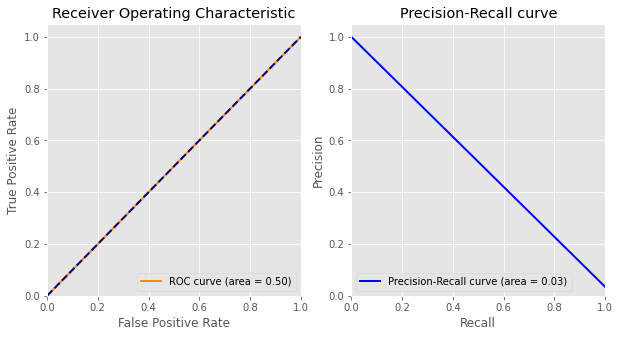

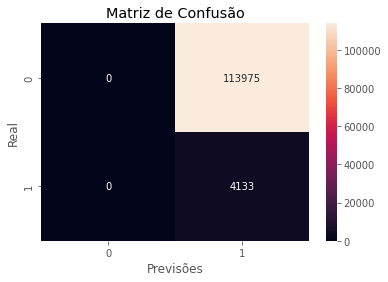

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    113975
           1       0.03      1.00      0.07      4133

    accuracy                           0.03    118108
   macro avg       0.02      0.50      0.03    118108
weighted avg       0.00      0.03      0.00    118108

CPU times: user 11min 22s, sys: 9.04 s, total: 11min 31s
Wall time: 11min 31s


In [110]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3212565755353042
F1-Score Negativo (Teste): 0.9588674518114754
F1-Score Positivo Médio (Validação Cruzada): 0.34266894920538027
F1-Score Positivo Fold 1: 0.35452793834296725
F1-Score Positivo Fold 2: 0.3147792706333973
F1-Score Positivo Fold 3: 0.3288718929254302
F1-Score Positivo Fold 4: 0.332688588007737
F1-Score Positivo Fold 5: 0.31800766283524906
F1-Score Positivo Fold 6: 0.3339731285988483
F1-Score Positivo Fold 7: 0.34146341463414637
F1-Score Positivo Fold 8: 0.37037037037037035
F1-Score Positivo Fold 9: 0.3639774859287055
F1-Score Positivo Fold 10: 0.36802973977695164
F1-Score Negativo Médio (Validação Cruzada): 0.985014047822278
F1-Score Negativo Fold 1: 0.9854997186512574
F1-Score Negativo Fold 2: 0.9845461235444353
F1-Score Negativo Fold 3: 0.9848045369929436
F1-Score Negativo Fold 4: 0.9850681670634063
F1-Score Negativo Fold 5: 0.9845887445887445
F1-Score Negativo Fold 6: 0.9849790052378685
F1-Score Negativo Fold 7: 0.9847979557364979
F1-Score N

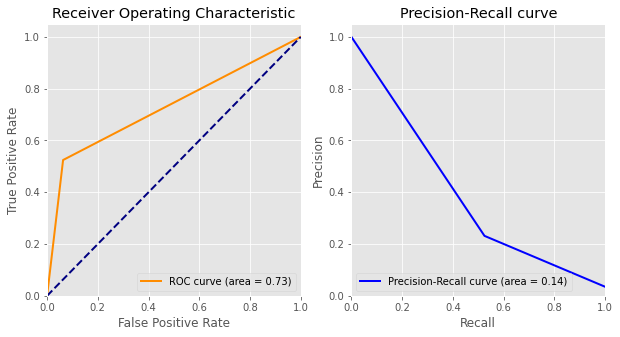

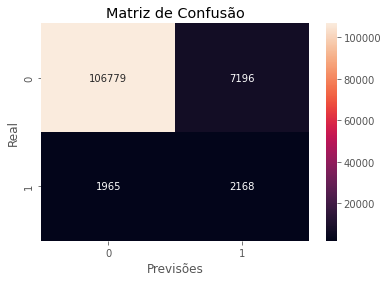

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.52      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 11min 22s, sys: 8.99 s, total: 11min 31s
Wall time: 11min 31s


In [111]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.0
F1-Score Negativo (Teste): 0.9821917158947445
F1-Score Positivo Médio (Validação Cruzada): 0.34266894920538027
F1-Score Positivo Fold 1: 0.35452793834296725
F1-Score Positivo Fold 2: 0.3147792706333973
F1-Score Positivo Fold 3: 0.3288718929254302
F1-Score Positivo Fold 4: 0.332688588007737
F1-Score Positivo Fold 5: 0.31800766283524906
F1-Score Positivo Fold 6: 0.3339731285988483
F1-Score Positivo Fold 7: 0.34146341463414637
F1-Score Positivo Fold 8: 0.37037037037037035
F1-Score Positivo Fold 9: 0.3639774859287055
F1-Score Positivo Fold 10: 0.36802973977695164
F1-Score Negativo Médio (Validação Cruzada): 0.985014047822278
F1-Score Negativo Fold 1: 0.9854997186512574
F1-Score Negativo Fold 2: 0.9845461235444353
F1-Score Negativo Fold 3: 0.9848045369929436
F1-Score Negativo Fold 4: 0.9850681670634063
F1-Score Negativo Fold 5: 0.9845887445887445
F1-Score Negativo Fold 6: 0.9849790052378685
F1-Score Negativo Fold 7: 0.9847979557364979
F1-Score Negativo Fold 8:

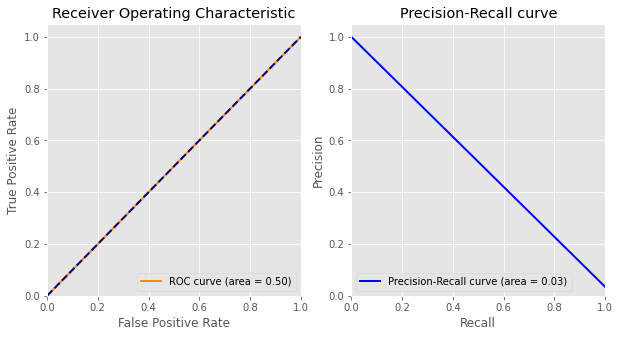

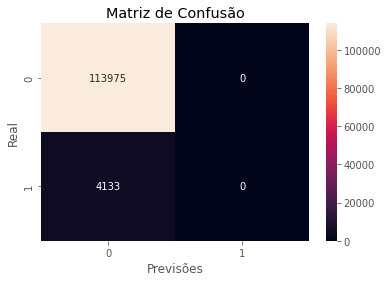

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.00      0.00      0.00      4133

    accuracy                           0.97    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.97      0.95    118108

CPU times: user 11min 23s, sys: 8.69 s, total: 11min 31s
Wall time: 11min 31s


In [112]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

### KNN

F1-Score Positivo (Teste): 0.2680786390155415
F1-Score Negativo (Teste): 0.9308262942558347
F1-Score Positivo Médio (Validação Cruzada): 0.26571656066898897
F1-Score Positivo Fold 1: 0.23571428571428574
F1-Score Positivo Fold 2: 0.2867012089810017
F1-Score Positivo Fold 3: 0.27796610169491526
F1-Score Positivo Fold 4: 0.24832214765100674
F1-Score Positivo Fold 5: 0.2664359861591695
F1-Score Positivo Fold 6: 0.2572898799313894
F1-Score Positivo Fold 7: 0.28327645051194544
F1-Score Positivo Fold 8: 0.23875432525951554
F1-Score Positivo Fold 9: 0.27597955706984667
F1-Score Positivo Fold 10: 0.2867256637168141
F1-Score Negativo Médio (Validação Cruzada): 0.9815114279121293
F1-Score Negativo Fold 1: 0.9814413320613997
F1-Score Negativo Fold 2: 0.9820769865034934
F1-Score Negativo Fold 3: 0.9815039944425147
F1-Score Negativo Fold 4: 0.9805437331711978
F1-Score Negativo Fold 5: 0.9816004165943413
F1-Score Negativo Fold 6: 0.9812057815009332
F1-Score Negativo Fold 7: 0.9817676679979163
F1-Scor

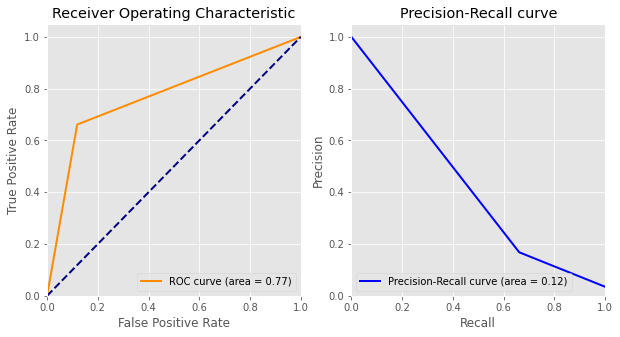

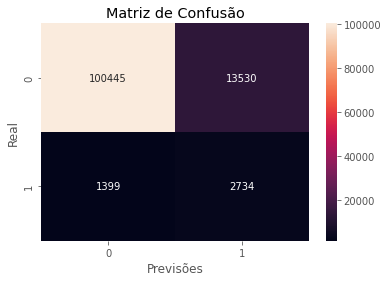

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113975
           1       0.17      0.66      0.27      4133

    accuracy                           0.87    118108
   macro avg       0.58      0.77      0.60    118108
weighted avg       0.96      0.87      0.91    118108

CPU times: user 39min 27s, sys: 1.22 s, total: 39min 28s
Wall time: 3min 27s


In [113]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3245492371705964
F1-Score Negativo (Teste): 0.9537396811036978
F1-Score Positivo Médio (Validação Cruzada): 0.26571656066898897
F1-Score Positivo Fold 1: 0.23571428571428574
F1-Score Positivo Fold 2: 0.2867012089810017
F1-Score Positivo Fold 3: 0.27796610169491526
F1-Score Positivo Fold 4: 0.24832214765100674
F1-Score Positivo Fold 5: 0.2664359861591695
F1-Score Positivo Fold 6: 0.2572898799313894
F1-Score Positivo Fold 7: 0.28327645051194544
F1-Score Positivo Fold 8: 0.23875432525951554
F1-Score Positivo Fold 9: 0.27597955706984667
F1-Score Positivo Fold 10: 0.2867256637168141
F1-Score Negativo Médio (Validação Cruzada): 0.9815114279121293
F1-Score Negativo Fold 1: 0.9814413320613997
F1-Score Negativo Fold 2: 0.9820769865034934
F1-Score Negativo Fold 3: 0.9815039944425147
F1-Score Negativo Fold 4: 0.9805437331711978
F1-Score Negativo Fold 5: 0.9816004165943413
F1-Score Negativo Fold 6: 0.9812057815009332
F1-Score Negativo Fold 7: 0.9817676679979163
F1-Scor

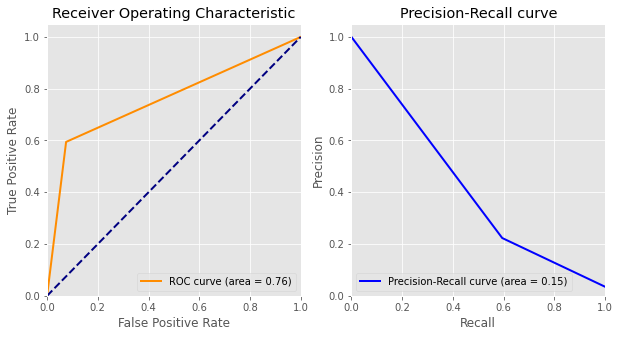

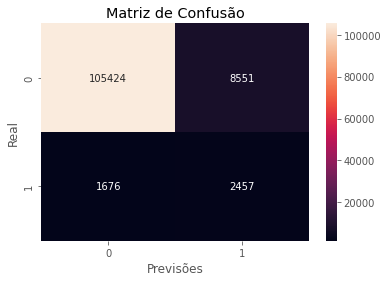

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 40min 11s, sys: 1.35 s, total: 40min 12s
Wall time: 3min 30s


In [114]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.4029073764856104
F1-Score Negativo (Teste): 0.9731059349215829
F1-Score Positivo Médio (Validação Cruzada): 0.26571656066898897
F1-Score Positivo Fold 1: 0.23571428571428574
F1-Score Positivo Fold 2: 0.2867012089810017
F1-Score Positivo Fold 3: 0.27796610169491526
F1-Score Positivo Fold 4: 0.24832214765100674
F1-Score Positivo Fold 5: 0.2664359861591695
F1-Score Positivo Fold 6: 0.2572898799313894
F1-Score Positivo Fold 7: 0.28327645051194544
F1-Score Positivo Fold 8: 0.23875432525951554
F1-Score Positivo Fold 9: 0.27597955706984667
F1-Score Positivo Fold 10: 0.2867256637168141
F1-Score Negativo Médio (Validação Cruzada): 0.9815114279121293
F1-Score Negativo Fold 1: 0.9814413320613997
F1-Score Negativo Fold 2: 0.9820769865034934
F1-Score Negativo Fold 3: 0.9815039944425147
F1-Score Negativo Fold 4: 0.9805437331711978
F1-Score Negativo Fold 5: 0.9816004165943413
F1-Score Negativo Fold 6: 0.9812057815009332
F1-Score Negativo Fold 7: 0.9817676679979163
F1-Scor

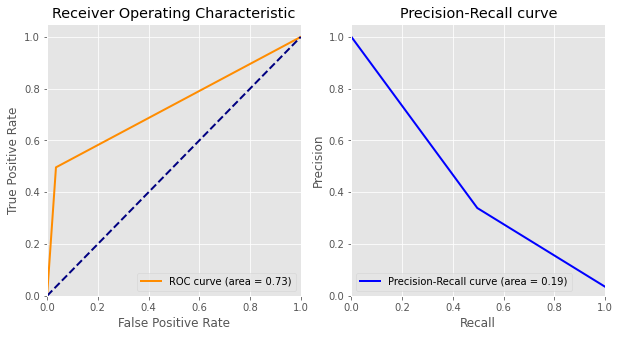

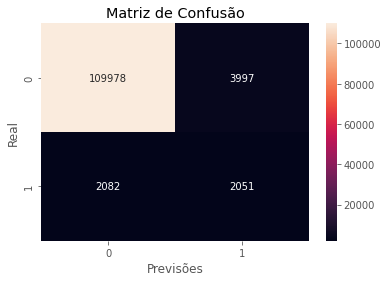

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.34      0.50      0.40      4133

    accuracy                           0.95    118108
   macro avg       0.66      0.73      0.69    118108
weighted avg       0.96      0.95      0.95    118108

CPU times: user 40min 17s, sys: 1.2 s, total: 40min 18s
Wall time: 3min 30s


In [115]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

## Validação Cruzada para Oversample com AdaSyn

### 75 Chi-Square

In [116]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.5858642669666292
F1-Score Negativo (Teste): 0.9804121517371025
F1-Score Positivo Médio (Validação Cruzada): 0.5056798363438724
F1-Score Positivo Fold 1: 0.4973730297723292
F1-Score Positivo Fold 2: 0.49491525423728816
F1-Score Positivo Fold 3: 0.4947368421052632
F1-Score Positivo Fold 4: 0.4807017543859649
F1-Score Positivo Fold 5: 0.47787610619469034
F1-Score Positivo Fold 6: 0.5137931034482759
F1-Score Positivo Fold 7: 0.5008576329331047
F1-Score Positivo Fold 8: 0.5223367697594502
F1-Score Positivo Fold 9: 0.5585284280936454
F1-Score Positivo Fold 10: 0.5156794425087108
F1-Score Negativo Médio (Validação Cruzada): 0.9876017047474202
F1-Score Negativo Fold 1: 0.9875493470999089
F1-Score Negativo Fold 2: 0.9870614796804446
F1-Score Negativo Fold 3: 0.9875065070275898
F1-Score Negativo Fold 4: 0.987159465556134
F1-Score Negativo Fold 5: 0.9872056208526695
F1-Score Negativo Fold 6: 0.9877614790382779
F1-Score Negativo Fold 7: 0.9873692434567473
F1-Score Nega

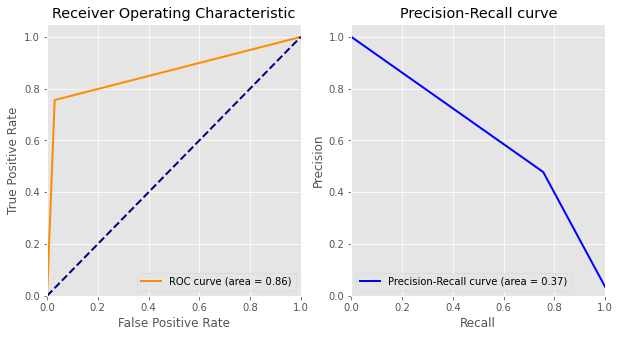

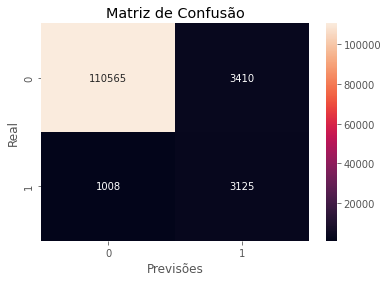

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    113975
           1       0.48      0.76      0.59      4133

    accuracy                           0.96    118108
   macro avg       0.73      0.86      0.78    118108
weighted avg       0.97      0.96      0.97    118108

CPU times: user 5min 51s, sys: 341 ms, total: 5min 51s
Wall time: 5min 51s


In [117]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.6708038678019916
F1-Score Negativo (Teste): 0.9900517691801105
F1-Score Positivo Médio (Validação Cruzada): 0.5056798363438724
F1-Score Positivo Fold 1: 0.4973730297723292
F1-Score Positivo Fold 2: 0.49491525423728816
F1-Score Positivo Fold 3: 0.4947368421052632
F1-Score Positivo Fold 4: 0.4807017543859649
F1-Score Positivo Fold 5: 0.47787610619469034
F1-Score Positivo Fold 6: 0.5137931034482759
F1-Score Positivo Fold 7: 0.5008576329331047
F1-Score Positivo Fold 8: 0.5223367697594502
F1-Score Positivo Fold 9: 0.5585284280936454
F1-Score Positivo Fold 10: 0.5156794425087108
F1-Score Negativo Médio (Validação Cruzada): 0.9876017047474202
F1-Score Negativo Fold 1: 0.9875493470999089
F1-Score Negativo Fold 2: 0.9870614796804446
F1-Score Negativo Fold 3: 0.9875065070275898
F1-Score Negativo Fold 4: 0.987159465556134
F1-Score Negativo Fold 5: 0.9872056208526695
F1-Score Negativo Fold 6: 0.9877614790382779
F1-Score Negativo Fold 7: 0.9873692434567473
F1-Score Nega

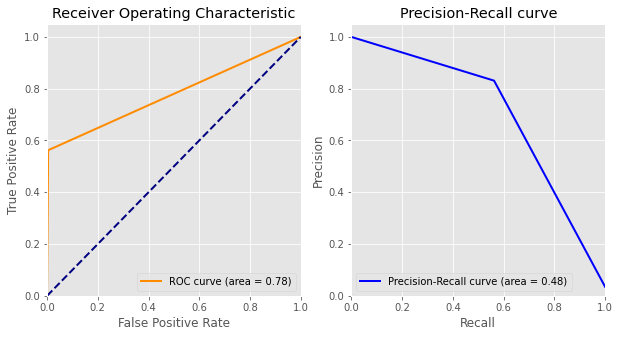

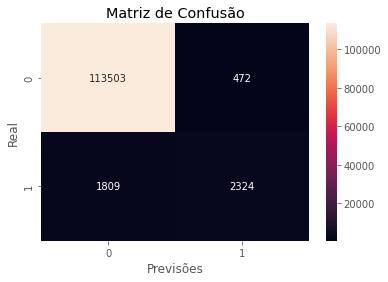

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.83      0.56      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.91      0.78      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 5min 50s, sys: 297 ms, total: 5min 50s
Wall time: 5min 50s


In [118]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.5696139060671904
F1-Score Negativo (Teste): 0.988815678030517
F1-Score Positivo Médio (Validação Cruzada): 0.5056798363438724
F1-Score Positivo Fold 1: 0.4973730297723292
F1-Score Positivo Fold 2: 0.49491525423728816
F1-Score Positivo Fold 3: 0.4947368421052632
F1-Score Positivo Fold 4: 0.4807017543859649
F1-Score Positivo Fold 5: 0.47787610619469034
F1-Score Positivo Fold 6: 0.5137931034482759
F1-Score Positivo Fold 7: 0.5008576329331047
F1-Score Positivo Fold 8: 0.5223367697594502
F1-Score Positivo Fold 9: 0.5585284280936454
F1-Score Positivo Fold 10: 0.5156794425087108
F1-Score Negativo Médio (Validação Cruzada): 0.9876017047474202
F1-Score Negativo Fold 1: 0.9875493470999089
F1-Score Negativo Fold 2: 0.9870614796804446
F1-Score Negativo Fold 3: 0.9875065070275898
F1-Score Negativo Fold 4: 0.987159465556134
F1-Score Negativo Fold 5: 0.9872056208526695
F1-Score Negativo Fold 6: 0.9877614790382779
F1-Score Negativo Fold 7: 0.9873692434567473
F1-Score Negat

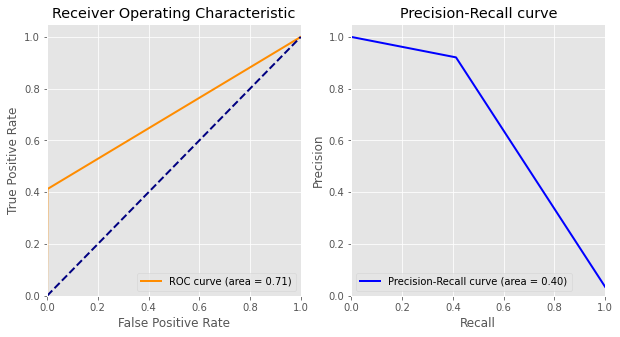

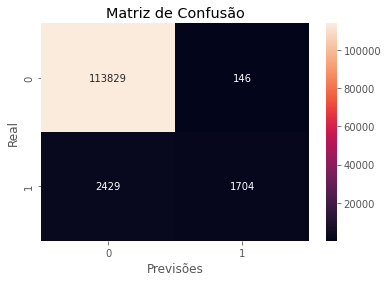

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.92      0.41      0.57      4133

    accuracy                           0.98    118108
   macro avg       0.95      0.71      0.78    118108
weighted avg       0.98      0.98      0.97    118108

CPU times: user 5min 50s, sys: 340 ms, total: 5min 51s
Wall time: 5min 50s


In [119]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Decision Tree

F1-Score Positivo (Teste): 0.4828030954428203
F1-Score Negativo (Teste): 0.9787935411084473
F1-Score Positivo Médio (Validação Cruzada): 0.4213740466296751
F1-Score Positivo Fold 1: 0.44495944380069524
F1-Score Positivo Fold 2: 0.40369088811995385
F1-Score Positivo Fold 3: 0.4385763490241102
F1-Score Positivo Fold 4: 0.4059633027522936
F1-Score Positivo Fold 5: 0.416
F1-Score Positivo Fold 6: 0.41014332965821393
F1-Score Positivo Fold 7: 0.4234234234234234
F1-Score Positivo Fold 8: 0.43763676148796493
F1-Score Positivo Fold 9: 0.40175631174533477
F1-Score Positivo Fold 10: 0.43159065628476084
F1-Score Negativo Médio (Validação Cruzada): 0.9774307057989013
F1-Score Negativo Fold 1: 0.9789533810800124
F1-Score Negativo Fold 2: 0.9772797187431334
F1-Score Negativo Fold 3: 0.9785064392773944
F1-Score Negativo Fold 4: 0.9772307692307692
F1-Score Negativo Fold 5: 0.9775354991867059
F1-Score Negativo Fold 6: 0.9764472815320272
F1-Score Negativo Fold 7: 0.9774786663147707
F1-Score Negativo Fol

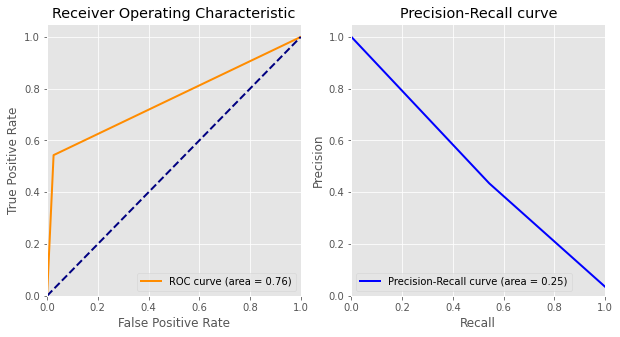

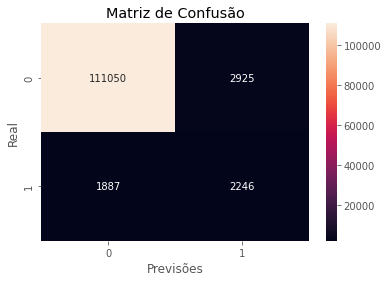

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.43      0.54      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.76      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 12s, sys: 304 ms, total: 1min 12s
Wall time: 1min 12s


In [120]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.48311464831146483
F1-Score Negativo (Teste): 0.9788205431036762
F1-Score Positivo Médio (Validação Cruzada): 0.4213740466296751
F1-Score Positivo Fold 1: 0.44495944380069524
F1-Score Positivo Fold 2: 0.40369088811995385
F1-Score Positivo Fold 3: 0.4385763490241102
F1-Score Positivo Fold 4: 0.4059633027522936
F1-Score Positivo Fold 5: 0.416
F1-Score Positivo Fold 6: 0.41014332965821393
F1-Score Positivo Fold 7: 0.4234234234234234
F1-Score Positivo Fold 8: 0.43763676148796493
F1-Score Positivo Fold 9: 0.40175631174533477
F1-Score Positivo Fold 10: 0.43159065628476084
F1-Score Negativo Médio (Validação Cruzada): 0.9774307057989013
F1-Score Negativo Fold 1: 0.9789533810800124
F1-Score Negativo Fold 2: 0.9772797187431334
F1-Score Negativo Fold 3: 0.9785064392773944
F1-Score Negativo Fold 4: 0.9772307692307692
F1-Score Negativo Fold 5: 0.9775354991867059
F1-Score Negativo Fold 6: 0.9764472815320272
F1-Score Negativo Fold 7: 0.9774786663147707
F1-Score Negativo Fo

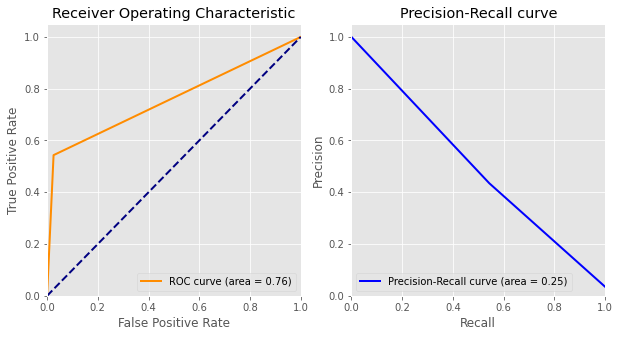

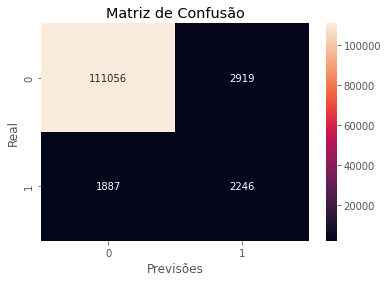

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.43      0.54      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.76      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 12s, sys: 324 ms, total: 1min 12s
Wall time: 1min 12s


In [121]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.48316661288587714
F1-Score Negativo (Teste): 0.9788250432973881
F1-Score Positivo Médio (Validação Cruzada): 0.4213740466296751
F1-Score Positivo Fold 1: 0.44495944380069524
F1-Score Positivo Fold 2: 0.40369088811995385
F1-Score Positivo Fold 3: 0.4385763490241102
F1-Score Positivo Fold 4: 0.4059633027522936
F1-Score Positivo Fold 5: 0.416
F1-Score Positivo Fold 6: 0.41014332965821393
F1-Score Positivo Fold 7: 0.4234234234234234
F1-Score Positivo Fold 8: 0.43763676148796493
F1-Score Positivo Fold 9: 0.40175631174533477
F1-Score Positivo Fold 10: 0.43159065628476084
F1-Score Negativo Médio (Validação Cruzada): 0.9774307057989013
F1-Score Negativo Fold 1: 0.9789533810800124
F1-Score Negativo Fold 2: 0.9772797187431334
F1-Score Negativo Fold 3: 0.9785064392773944
F1-Score Negativo Fold 4: 0.9772307692307692
F1-Score Negativo Fold 5: 0.9775354991867059
F1-Score Negativo Fold 6: 0.9764472815320272
F1-Score Negativo Fold 7: 0.9774786663147707
F1-Score Negativo Fo

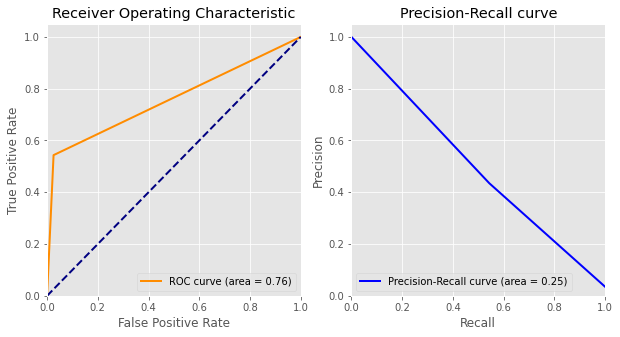

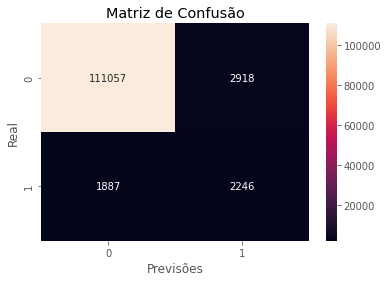

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.43      0.54      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.76      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 12s, sys: 304 ms, total: 1min 12s
Wall time: 1min 12s


In [122]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### CatBoost

0:	learn: 0.6205931	total: 67.1ms	remaining: 268ms
1:	learn: 0.5571825	total: 134ms	remaining: 201ms
2:	learn: 0.5056703	total: 202ms	remaining: 135ms
3:	learn: 0.4683129	total: 271ms	remaining: 67.9ms
4:	learn: 0.4402896	total: 338ms	remaining: 0us
0:	learn: 0.5357042	total: 13.4ms	remaining: 53.5ms
1:	learn: 0.4277623	total: 22.9ms	remaining: 34.3ms
2:	learn: 0.3476703	total: 30.6ms	remaining: 20.4ms
3:	learn: 0.2942769	total: 37.7ms	remaining: 9.44ms
4:	learn: 0.2490311	total: 45.2ms	remaining: 0us
0:	learn: 0.5351374	total: 7.41ms	remaining: 29.6ms
1:	learn: 0.4273847	total: 14.6ms	remaining: 21.8ms
2:	learn: 0.3471251	total: 22ms	remaining: 14.7ms
3:	learn: 0.2937767	total: 29.1ms	remaining: 7.28ms
4:	learn: 0.2486989	total: 36.5ms	remaining: 0us
0:	learn: 0.5356379	total: 13.5ms	remaining: 54ms
1:	learn: 0.4272701	total: 22.6ms	remaining: 33.9ms
2:	learn: 0.3470566	total: 30.4ms	remaining: 20.3ms
3:	learn: 0.2937291	total: 37.5ms	remaining: 9.38ms
4:	learn: 0.2495533	total: 45.3m

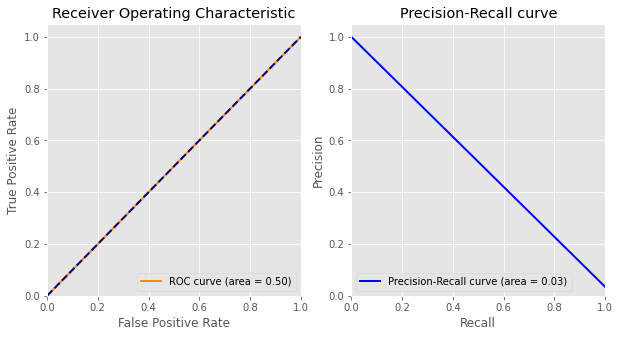

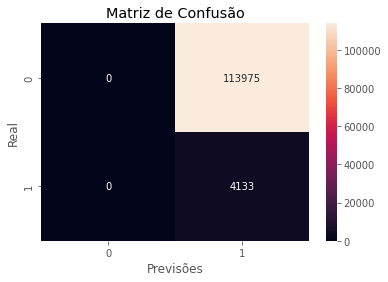

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    113975
           1       0.03      1.00      0.07      4133

    accuracy                           0.03    118108
   macro avg       0.02      0.50      0.03    118108
weighted avg       0.00      0.03      0.00    118108

CPU times: user 37.4 s, sys: 671 ms, total: 38.1 s
Wall time: 20.7 s


In [123]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

0:	learn: 0.6205931	total: 68.6ms	remaining: 274ms
1:	learn: 0.5571825	total: 135ms	remaining: 203ms
2:	learn: 0.5056703	total: 205ms	remaining: 137ms
3:	learn: 0.4683129	total: 273ms	remaining: 68.3ms
4:	learn: 0.4402896	total: 339ms	remaining: 0us
0:	learn: 0.5357042	total: 7.28ms	remaining: 29.1ms
1:	learn: 0.4277623	total: 14.6ms	remaining: 22ms
2:	learn: 0.3476703	total: 21.9ms	remaining: 14.6ms
3:	learn: 0.2942769	total: 29.1ms	remaining: 7.26ms
4:	learn: 0.2490311	total: 36.6ms	remaining: 0us
0:	learn: 0.5351374	total: 13.6ms	remaining: 54.4ms
1:	learn: 0.4273847	total: 23.1ms	remaining: 34.7ms
2:	learn: 0.3471251	total: 31.2ms	remaining: 20.8ms
3:	learn: 0.2937767	total: 38.8ms	remaining: 9.7ms
4:	learn: 0.2486989	total: 46.2ms	remaining: 0us
0:	learn: 0.5356379	total: 7.19ms	remaining: 28.8ms
1:	learn: 0.4272701	total: 14.4ms	remaining: 21.7ms
2:	learn: 0.3470566	total: 21.6ms	remaining: 14.4ms
3:	learn: 0.2937291	total: 28.7ms	remaining: 7.18ms
4:	learn: 0.2495533	total: 36.8

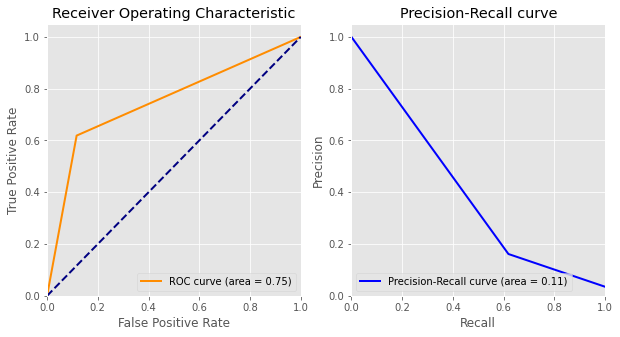

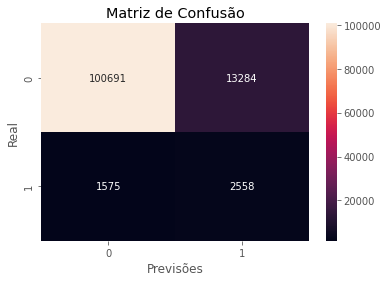

              precision    recall  f1-score   support

           0       0.98      0.88      0.93    113975
           1       0.16      0.62      0.26      4133

    accuracy                           0.87    118108
   macro avg       0.57      0.75      0.59    118108
weighted avg       0.96      0.87      0.91    118108

CPU times: user 37.7 s, sys: 855 ms, total: 38.6 s
Wall time: 21.1 s


In [124]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

0:	learn: 0.6205931	total: 74.3ms	remaining: 297ms
1:	learn: 0.5571825	total: 142ms	remaining: 213ms
2:	learn: 0.5056703	total: 210ms	remaining: 140ms
3:	learn: 0.4683129	total: 279ms	remaining: 69.7ms
4:	learn: 0.4402896	total: 343ms	remaining: 0us
0:	learn: 0.5357042	total: 12.5ms	remaining: 49.9ms
1:	learn: 0.4277623	total: 21.7ms	remaining: 32.6ms
2:	learn: 0.3476703	total: 29.6ms	remaining: 19.7ms
3:	learn: 0.2942769	total: 36.7ms	remaining: 9.17ms
4:	learn: 0.2490311	total: 44.2ms	remaining: 0us
0:	learn: 0.5351374	total: 13.1ms	remaining: 52.5ms
1:	learn: 0.4273847	total: 22.4ms	remaining: 33.7ms
2:	learn: 0.3471251	total: 30.3ms	remaining: 20.2ms
3:	learn: 0.2937767	total: 37.3ms	remaining: 9.34ms
4:	learn: 0.2486989	total: 44.9ms	remaining: 0us
0:	learn: 0.5356379	total: 12.9ms	remaining: 51.6ms
1:	learn: 0.4272701	total: 22ms	remaining: 33.1ms
2:	learn: 0.3470566	total: 29.6ms	remaining: 19.7ms
3:	learn: 0.2937291	total: 36.7ms	remaining: 9.18ms
4:	learn: 0.2495533	total: 44.

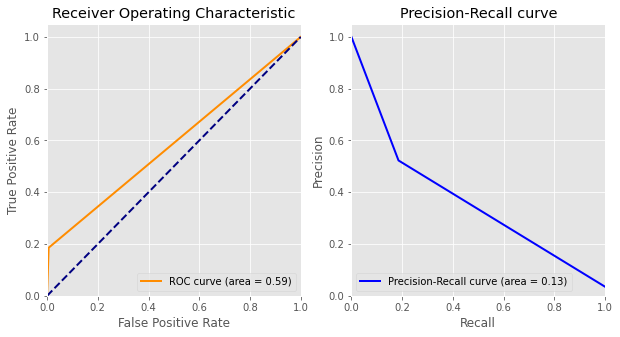

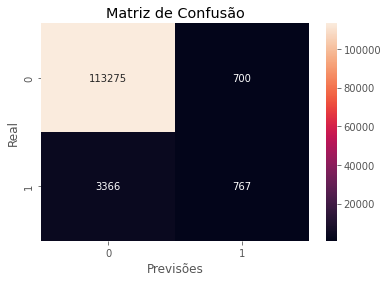

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    113975
           1       0.52      0.19      0.27      4133

    accuracy                           0.97    118108
   macro avg       0.75      0.59      0.63    118108
weighted avg       0.96      0.97      0.96    118108

CPU times: user 37.6 s, sys: 819 ms, total: 38.4 s
Wall time: 21.3 s


In [125]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Gradient Boosting

F1-Score Positivo (Teste): 0.18599063578117297
F1-Score Negativo (Teste): 0.8703031135890691
F1-Score Positivo Médio (Validação Cruzada): 0.31477911929845276
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.3529411764705882
F1-Score Positivo Fold 3: 0.358974358974359
F1-Score Positivo Fold 4: 0.3650190114068441
F1-Score Positivo Fold 5: 0.3402646502835539
F1-Score Positivo Fold 6: 0.35820895522388063
F1-Score Positivo Fold 7: 0.34651600753295664
F1-Score Positivo Fold 8: 0.40510948905109495
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.39332096474953615
F1-Score Negativo Médio (Validação Cruzada): 0.9844870775997263
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.985234899328859
F1-Score Negativo Fold 3: 0.9848327266423991
F1-Score Negativo Fold 4: 0.9855386214063041
F1-Score Negativo Fold 5: 0.9848871952539731
F1-Score Negativo Fold 6: 0.985099194316902
F1-Score Negativo Fold 7: 0.9849725001082673
F1-Score N

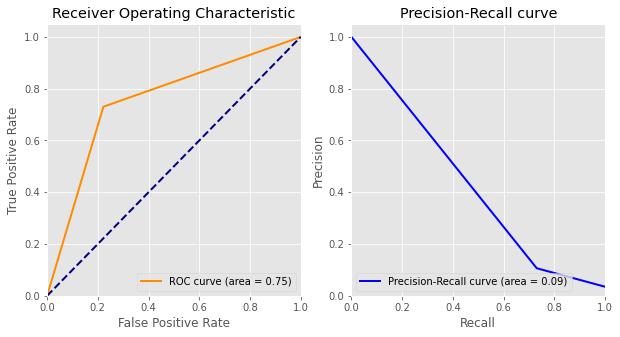

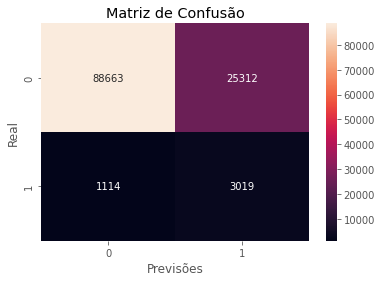

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    113975
           1       0.11      0.73      0.19      4133

    accuracy                           0.78    118108
   macro avg       0.55      0.75      0.53    118108
weighted avg       0.96      0.78      0.85    118108

CPU times: user 6min 44s, sys: 353 ms, total: 6min 44s
Wall time: 6min 44s


In [126]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.33882312575055756
F1-Score Negativo (Teste): 0.9656747922585702
F1-Score Positivo Médio (Validação Cruzada): 0.31477911929845276
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.3529411764705882
F1-Score Positivo Fold 3: 0.358974358974359
F1-Score Positivo Fold 4: 0.3650190114068441
F1-Score Positivo Fold 5: 0.3402646502835539
F1-Score Positivo Fold 6: 0.35820895522388063
F1-Score Positivo Fold 7: 0.34651600753295664
F1-Score Positivo Fold 8: 0.40510948905109495
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.39332096474953615
F1-Score Negativo Médio (Validação Cruzada): 0.9844870775997263
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.985234899328859
F1-Score Negativo Fold 3: 0.9848327266423991
F1-Score Negativo Fold 4: 0.9855386214063041
F1-Score Negativo Fold 5: 0.9848871952539731
F1-Score Negativo Fold 6: 0.985099194316902
F1-Score Negativo Fold 7: 0.9849725001082673
F1-Score N

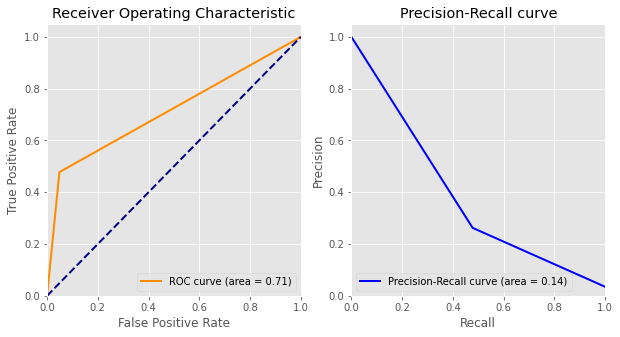

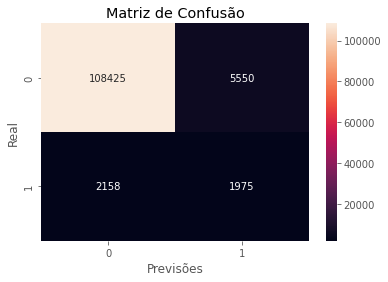

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.26      0.48      0.34      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.71      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 6min 43s, sys: 333 ms, total: 6min 43s
Wall time: 6min 43s


In [127]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3727917651968285
F1-Score Negativo (Teste): 0.9803123649176735
F1-Score Positivo Médio (Validação Cruzada): 0.31477911929845276
F1-Score Positivo Fold 1: 0.1029082774049217
F1-Score Positivo Fold 2: 0.3529411764705882
F1-Score Positivo Fold 3: 0.358974358974359
F1-Score Positivo Fold 4: 0.3650190114068441
F1-Score Positivo Fold 5: 0.3402646502835539
F1-Score Positivo Fold 6: 0.35820895522388063
F1-Score Positivo Fold 7: 0.34651600753295664
F1-Score Positivo Fold 8: 0.40510948905109495
F1-Score Positivo Fold 9: 0.12452830188679245
F1-Score Positivo Fold 10: 0.39332096474953615
F1-Score Negativo Médio (Validação Cruzada): 0.9844870775997263
F1-Score Negativo Fold 1: 0.9826968716289104
F1-Score Negativo Fold 2: 0.985234899328859
F1-Score Negativo Fold 3: 0.9848327266423991
F1-Score Negativo Fold 4: 0.9855386214063041
F1-Score Negativo Fold 5: 0.9848871952539731
F1-Score Negativo Fold 6: 0.985099194316902
F1-Score Negativo Fold 7: 0.9849725001082673
F1-Score Ne

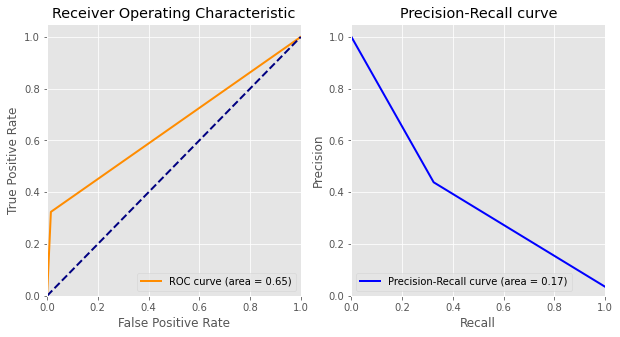

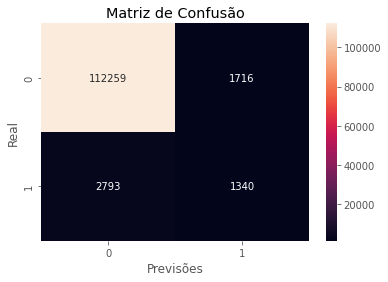

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.44      0.32      0.37      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.65      0.68    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 6min 47s, sys: 437 ms, total: 6min 47s
Wall time: 6min 47s


In [128]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### AdaBoost

F1-Score Positivo (Teste): 0.06762052012009064
F1-Score Negativo (Teste): 0.0
F1-Score Positivo Médio (Validação Cruzada): 0.336509648994055
F1-Score Positivo Fold 1: 0.31496062992125984
F1-Score Positivo Fold 2: 0.3186180422264875
F1-Score Positivo Fold 3: 0.3408239700374532
F1-Score Positivo Fold 4: 0.33073929961089493
F1-Score Positivo Fold 5: 0.3238095238095238
F1-Score Positivo Fold 6: 0.3371647509578544
F1-Score Positivo Fold 7: 0.32149532710280376
F1-Score Positivo Fold 8: 0.3609022556390978
F1-Score Positivo Fold 9: 0.3574144486692015
F1-Score Positivo Fold 10: 0.3591682419659735
F1-Score Negativo Médio (Validação Cruzada): 0.9849330934392967
F1-Score Negativo Fold 1: 0.9849441896685992
F1-Score Negativo Fold 2: 0.984632699883122
F1-Score Negativo Fold 3: 0.9847539847539848
F1-Score Negativo Fold 4: 0.9851133806473948
F1-Score Negativo Fold 5: 0.9846300385331428
F1-Score Negativo Fold 6: 0.9850216450216451
F1-Score Negativo Fold 7: 0.9842768657686144
F1-Score Negativo Fold 8: 0

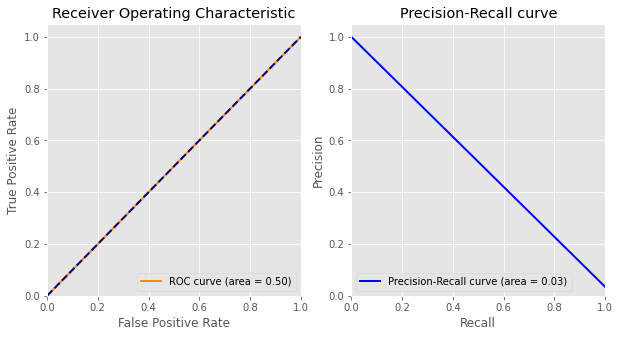

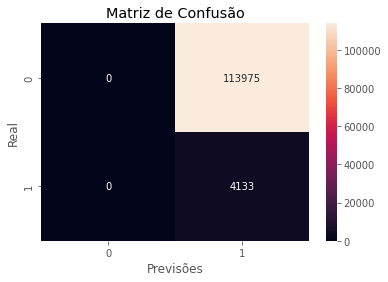

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    113975
           1       0.03      1.00      0.07      4133

    accuracy                           0.03    118108
   macro avg       0.02      0.50      0.03    118108
weighted avg       0.00      0.03      0.00    118108

CPU times: user 8min 3s, sys: 4.04 s, total: 8min 7s
Wall time: 8min 6s


In [129]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.31947585991732314
F1-Score Negativo (Teste): 0.9609436200452114
F1-Score Positivo Médio (Validação Cruzada): 0.336509648994055
F1-Score Positivo Fold 1: 0.31496062992125984
F1-Score Positivo Fold 2: 0.3186180422264875
F1-Score Positivo Fold 3: 0.3408239700374532
F1-Score Positivo Fold 4: 0.33073929961089493
F1-Score Positivo Fold 5: 0.3238095238095238
F1-Score Positivo Fold 6: 0.3371647509578544
F1-Score Positivo Fold 7: 0.32149532710280376
F1-Score Positivo Fold 8: 0.3609022556390978
F1-Score Positivo Fold 9: 0.3574144486692015
F1-Score Positivo Fold 10: 0.3591682419659735
F1-Score Negativo Médio (Validação Cruzada): 0.9849330934392967
F1-Score Negativo Fold 1: 0.9849441896685992
F1-Score Negativo Fold 2: 0.984632699883122
F1-Score Negativo Fold 3: 0.9847539847539848
F1-Score Negativo Fold 4: 0.9851133806473948
F1-Score Negativo Fold 5: 0.9846300385331428
F1-Score Negativo Fold 6: 0.9850216450216451
F1-Score Negativo Fold 7: 0.9842768657686144
F1-Score Neg

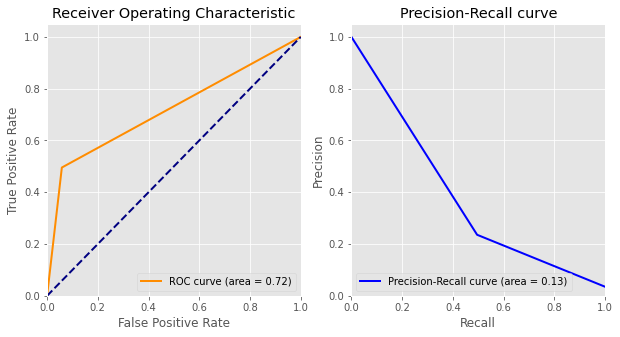

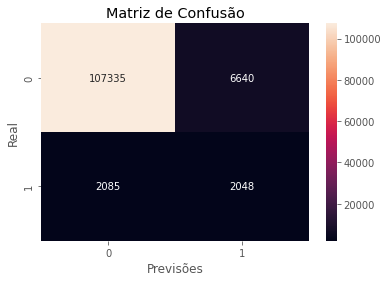

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.50      0.32      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.72      0.64    118108
weighted avg       0.95      0.93      0.94    118108

CPU times: user 8min 2s, sys: 4.57 s, total: 8min 6s
Wall time: 8min 6s


In [130]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.0
F1-Score Negativo (Teste): 0.9821917158947445
F1-Score Positivo Médio (Validação Cruzada): 0.336509648994055
F1-Score Positivo Fold 1: 0.31496062992125984
F1-Score Positivo Fold 2: 0.3186180422264875
F1-Score Positivo Fold 3: 0.3408239700374532
F1-Score Positivo Fold 4: 0.33073929961089493
F1-Score Positivo Fold 5: 0.3238095238095238
F1-Score Positivo Fold 6: 0.3371647509578544
F1-Score Positivo Fold 7: 0.32149532710280376
F1-Score Positivo Fold 8: 0.3609022556390978
F1-Score Positivo Fold 9: 0.3574144486692015
F1-Score Positivo Fold 10: 0.3591682419659735
F1-Score Negativo Médio (Validação Cruzada): 0.9849330934392967
F1-Score Negativo Fold 1: 0.9849441896685992
F1-Score Negativo Fold 2: 0.984632699883122
F1-Score Negativo Fold 3: 0.9847539847539848
F1-Score Negativo Fold 4: 0.9851133806473948
F1-Score Negativo Fold 5: 0.9846300385331428
F1-Score Negativo Fold 6: 0.9850216450216451
F1-Score Negativo Fold 7: 0.9842768657686144
F1-Score Negativo Fold 8: 0.

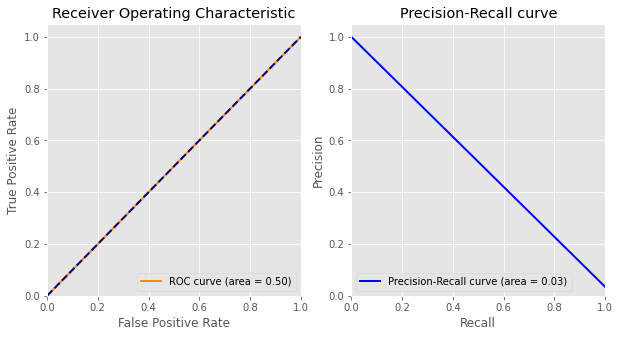

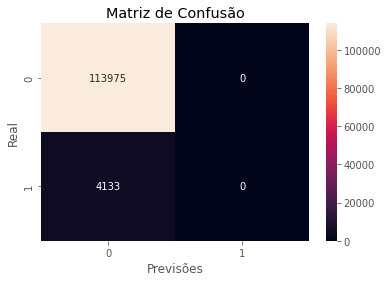

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.00      0.00      0.00      4133

    accuracy                           0.97    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.97      0.95    118108

CPU times: user 8min 2s, sys: 4.29 s, total: 8min 7s
Wall time: 8min 6s


In [131]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

### KNN

F1-Score Positivo (Teste): 0.26408877259291563
F1-Score Negativo (Teste): 0.9295525074334698
F1-Score Positivo Médio (Validação Cruzada): 0.2596650648164956
F1-Score Positivo Fold 1: 0.23362831858407082
F1-Score Positivo Fold 2: 0.288135593220339
F1-Score Positivo Fold 3: 0.26970227670753066
F1-Score Positivo Fold 4: 0.2402707275803722
F1-Score Positivo Fold 5: 0.24347826086956523
F1-Score Positivo Fold 6: 0.24822695035460995
F1-Score Positivo Fold 7: 0.2732049036777583
F1-Score Positivo Fold 8: 0.23752151462994833
F1-Score Positivo Fold 9: 0.2822719449225473
F1-Score Positivo Fold 10: 0.28021015761821366
F1-Score Negativo Médio (Validação Cruzada): 0.9814974811873766
F1-Score Negativo Fold 1: 0.981220453658325
F1-Score Negativo Fold 2: 0.9817645015630426
F1-Score Negativo Fold 3: 0.981909678538892
F1-Score Negativo Fold 4: 0.9805045373626851
F1-Score Negativo Fold 5: 0.9811255260988415
F1-Score Negativo Fold 6: 0.9816115881689652
F1-Score Negativo Fold 7: 0.9819964426706
F1-Score Nega

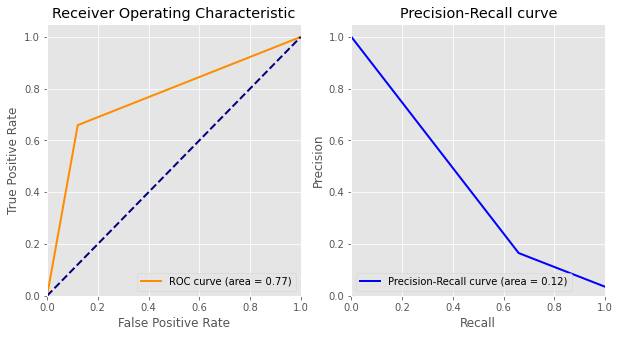

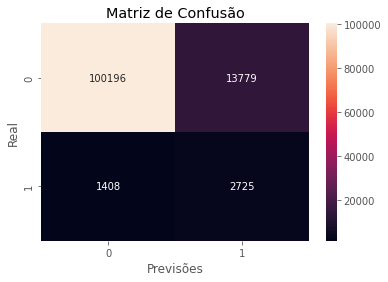

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113975
           1       0.17      0.66      0.26      4133

    accuracy                           0.87    118108
   macro avg       0.58      0.77      0.60    118108
weighted avg       0.96      0.87      0.91    118108

CPU times: user 22min 10s, sys: 999 ms, total: 22min 11s
Wall time: 1min 58s


In [132]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.3157826982492276
F1-Score Negativo (Teste): 0.9518307050933479
F1-Score Positivo Médio (Validação Cruzada): 0.2596650648164956
F1-Score Positivo Fold 1: 0.23362831858407082
F1-Score Positivo Fold 2: 0.288135593220339
F1-Score Positivo Fold 3: 0.26970227670753066
F1-Score Positivo Fold 4: 0.2402707275803722
F1-Score Positivo Fold 5: 0.24347826086956523
F1-Score Positivo Fold 6: 0.24822695035460995
F1-Score Positivo Fold 7: 0.2732049036777583
F1-Score Positivo Fold 8: 0.23752151462994833
F1-Score Positivo Fold 9: 0.2822719449225473
F1-Score Positivo Fold 10: 0.28021015761821366
F1-Score Negativo Médio (Validação Cruzada): 0.9814974811873766
F1-Score Negativo Fold 1: 0.981220453658325
F1-Score Negativo Fold 2: 0.9817645015630426
F1-Score Negativo Fold 3: 0.981909678538892
F1-Score Negativo Fold 4: 0.9805045373626851
F1-Score Negativo Fold 5: 0.9811255260988415
F1-Score Negativo Fold 6: 0.9816115881689652
F1-Score Negativo Fold 7: 0.9819964426706
F1-Score Negat

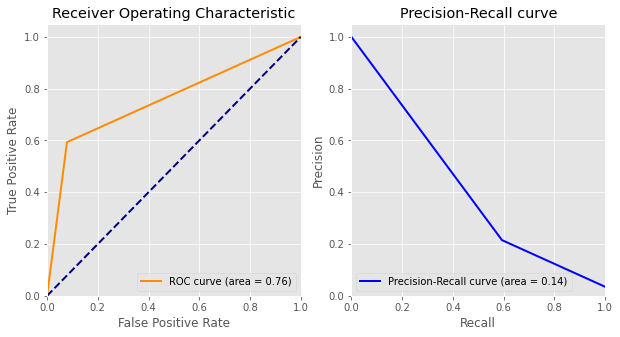

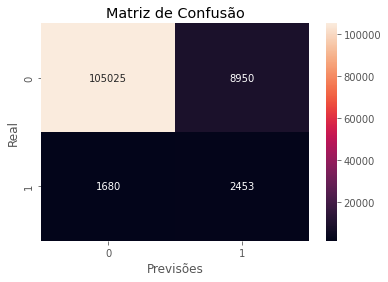

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 23min 6s, sys: 1.05 s, total: 23min 7s
Wall time: 2min 3s


In [133]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

F1-Score Positivo (Teste): 0.38824884792626724
F1-Score Negativo (Teste): 0.9717803365810452
F1-Score Positivo Médio (Validação Cruzada): 0.2596650648164956
F1-Score Positivo Fold 1: 0.23362831858407082
F1-Score Positivo Fold 2: 0.288135593220339
F1-Score Positivo Fold 3: 0.26970227670753066
F1-Score Positivo Fold 4: 0.2402707275803722
F1-Score Positivo Fold 5: 0.24347826086956523
F1-Score Positivo Fold 6: 0.24822695035460995
F1-Score Positivo Fold 7: 0.2732049036777583
F1-Score Positivo Fold 8: 0.23752151462994833
F1-Score Positivo Fold 9: 0.2822719449225473
F1-Score Positivo Fold 10: 0.28021015761821366
F1-Score Negativo Médio (Validação Cruzada): 0.9814974811873766
F1-Score Negativo Fold 1: 0.981220453658325
F1-Score Negativo Fold 2: 0.9817645015630426
F1-Score Negativo Fold 3: 0.981909678538892
F1-Score Negativo Fold 4: 0.9805045373626851
F1-Score Negativo Fold 5: 0.9811255260988415
F1-Score Negativo Fold 6: 0.9816115881689652
F1-Score Negativo Fold 7: 0.9819964426706
F1-Score Nega

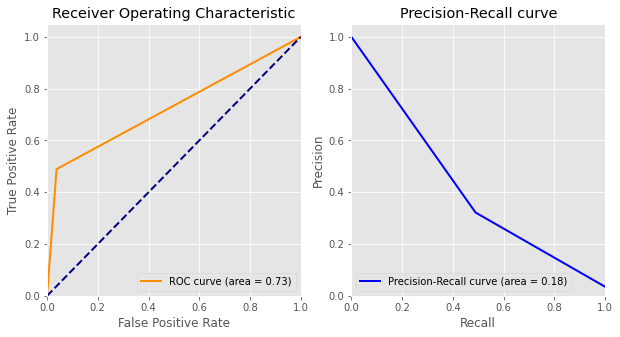

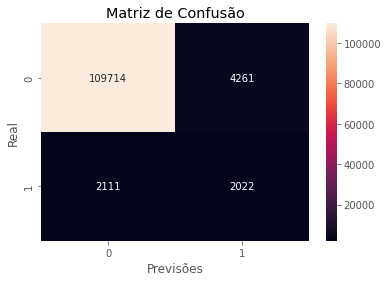

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.32      0.49      0.39      4133

    accuracy                           0.95    118108
   macro avg       0.65      0.73      0.68    118108
weighted avg       0.96      0.95      0.95    118108

CPU times: user 23min 4s, sys: 1.06 s, total: 23min 5s
Wall time: 2min 2s


In [134]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_75_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_75_chi2])[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_75_chi2], \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

### Todas as colunas

In [135]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

#### Extra Trees

In [136]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

SyntaxError: invalid syntax (<unknown>, line 33)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_et.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Decision Tree

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_dt.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### CatBoost

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_cb.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### Gradient Boosting

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_gbc.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### AdaBoost

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_ada.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

#### KNN

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.2

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.5

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [ ]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
probabilidades = clf_knn.predict_proba(X_test)[:, 1]

# Defina um limiar de classificação (por exemplo, 0.5)
limiar = 0.7

# Aplique o limiar para obter as predições binárias
previsoes = (probabilidades > limiar).astype(int)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Especificando o número de folds para a validação cruzada (10 é comum)
num_folds = 10

# Criando um objeto StratifiedKFold para garantir estratificação nos folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score2 pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = stratified_kfold, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_s2ore_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

# Cálculo tempo total do script

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))